# Matching kernel derivation in DFT space

We study two following "paradoxical" PSF matchings in this notebook:

### Matching kernel of well sampled, but close matching PSFs

Let's have two well sampled PSFs that are in the close-matching case. Their quadrature difference Gaussian, the matching kernel, is undersampled. It has a sigma < 0.95. Being undersampled means that this narrow matching kernel Gaussian function cannot be reconstructed from its pixellated values, and fractional pixel changes in its center position would alter the reconstructed model. The discrete Fourier transform (DFT) of such a pixellated image shows aliasing in general.

On the other hand, if we DFT the input PSFs, their ratio produce a matching kernel that do not show aliasing and up to the DFT frequency limit (0.5 1/px), it follows the Fourier transform of the theoretical solution. It is a frequency-cut version of the exact mathematical solution. Inverse DFTing this matching kernel into image space, it is not spatially well bounded, it has oscillating tails that span the entire image. But as demonstrated here, it works not only on the input PSFs that it was calculated from but matches perfectly the fractional pixel shifted instances of the same width input PSFs. This matching kernel seems to represent well an otherwise too narrow to sample Gaussian in our given dimension image space with using the circular convolution boundary condition.

We also know that there is a one-to-one, unambigous relation of a pixellated image and its DFT image, in accordance with the Nyquist-theorem and with the upper frequency limit (0.5 1/px) of the DFT space. This suggests that a matching kernel must be correct up to the Nyquist frequency only in order to work in (a fixed dimension) image space.

### Matching kernel of undersampled (and close matching) PSFs

The scipy shift operation uses 3rd order splines to shift (resample) the input images. As expected undersampled input PSFs produce artifacts in shift operations. However, the matching kernel that was deducted in DFT space seems to still match them perfectly even if shift artefacts are present in the inputs. We do not fully understand why the PSF matching works perfectly in this case. This suggests that the 3rd order spline shift preserves the DFT frequency space values of the input PSFs and the phases are also equal, so despite the visible artefacts on the inputs and on the matching kernel in image space, the matching works perfectly. 

----

We also demonstrate that if we disrupt the spectrum of the original PSFs by emulating saturation, oscillating tail artefacts appear in the matched difference in both scenarios. Of course the main signal subtraction is far from perfect in this case but this is expected.

We display the effect of fractional pixel centroiding errors. In the first case the positional error completely dominates the difference regardless of the matching, in the second case the matched difference still resembles more to the expected dipole although oscillating tails are present with or without matching.

Note, many of the slice plots are on symlog scales to show structure, but introduced oscillating structures are usually 2-3 orders magnitude smaller than the main signal. Play with commenting out the symlog setting.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.ndimage
from TwoD_gaussian_in_freq_space import calculate2dGaussianArray

In [2]:
from lsst.ip.diffim.zogy import ZogyTask, ZogyConfig
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)

### Well sampled inputs, well sampled difference

In [3]:
wSig1 = 3.31
wSig2 = 3.3
N = 64
print("Matching kernel sigma:",np.sqrt(wSig1**2 - wSig2**2))

Matching kernel sigma: 0.2570992026436532


In [4]:
# # Approach 1: calculate the matching kernel from the FFTd inputs
# # This adds the usual problem of not getting a reasonable value from the tails and must handle zero division, too
# # But, it works surprisingly well for matching
# A = calculate2dGaussianArray(N, N, wSig1)
# A /= np.sum(A)
# B = calculate2dGaussianArray(N, N, wSig2)
# B /= np.sum(B)
# pA = task.padCenterOriginArray(A, (N, N))
# psf1 = np.fft.fft2(pA)
# pB = task.padCenterOriginArray(B, (N, N))
# psf2 = np.fft.fft2(pB)

In [5]:
# Approach 2: calculate the matching kernel from directly Fourier space generated inputs
# For the matching kernel calculation, produce the FFTs directly in Fourier space
# This usually avoids zero division at this resolution, use this to avoid DFT tail noise 
# when the inputs are well sampled
# This does NOT produce aliasing. For undersampled inputs, use approach 1.
psf1 = calculate2dGaussianArray(N, N, wSig1, inFrequencySpace=True, fftShift=True)
psf2 = calculate2dGaussianArray(N, N, wSig2, inFrequencySpace=True, fftShift=True)

<IPython.core.display.Javascript object>


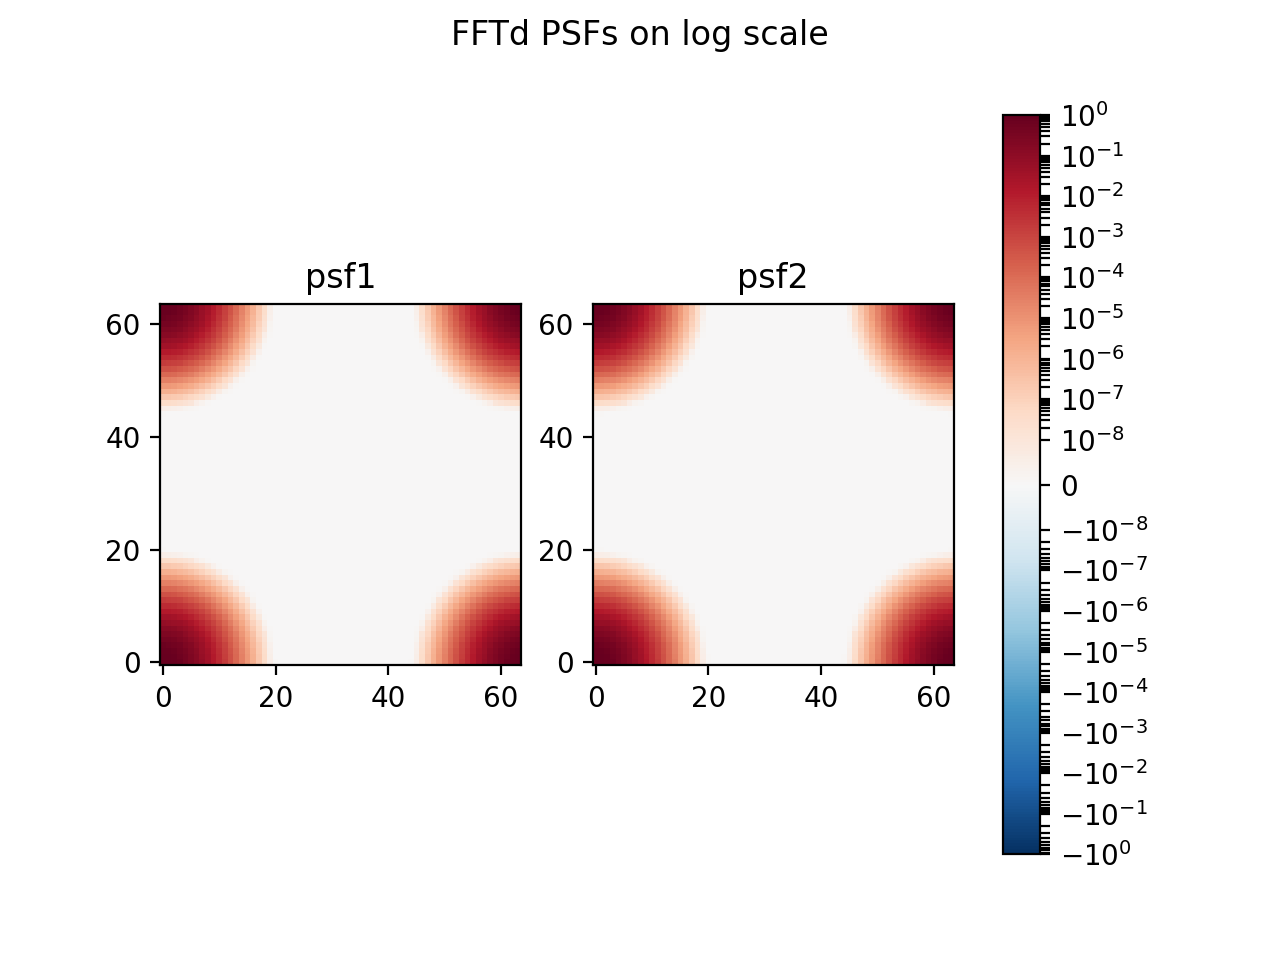

Text(0.5, 0.98, 'FFTd PSFs on log scale')

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(psf1.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("psf1")
cs = ax2.imshow(psf2.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1,vmax=1))
ax2.set_title("psf2")
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs on log scale")

<IPython.core.display.Javascript object>


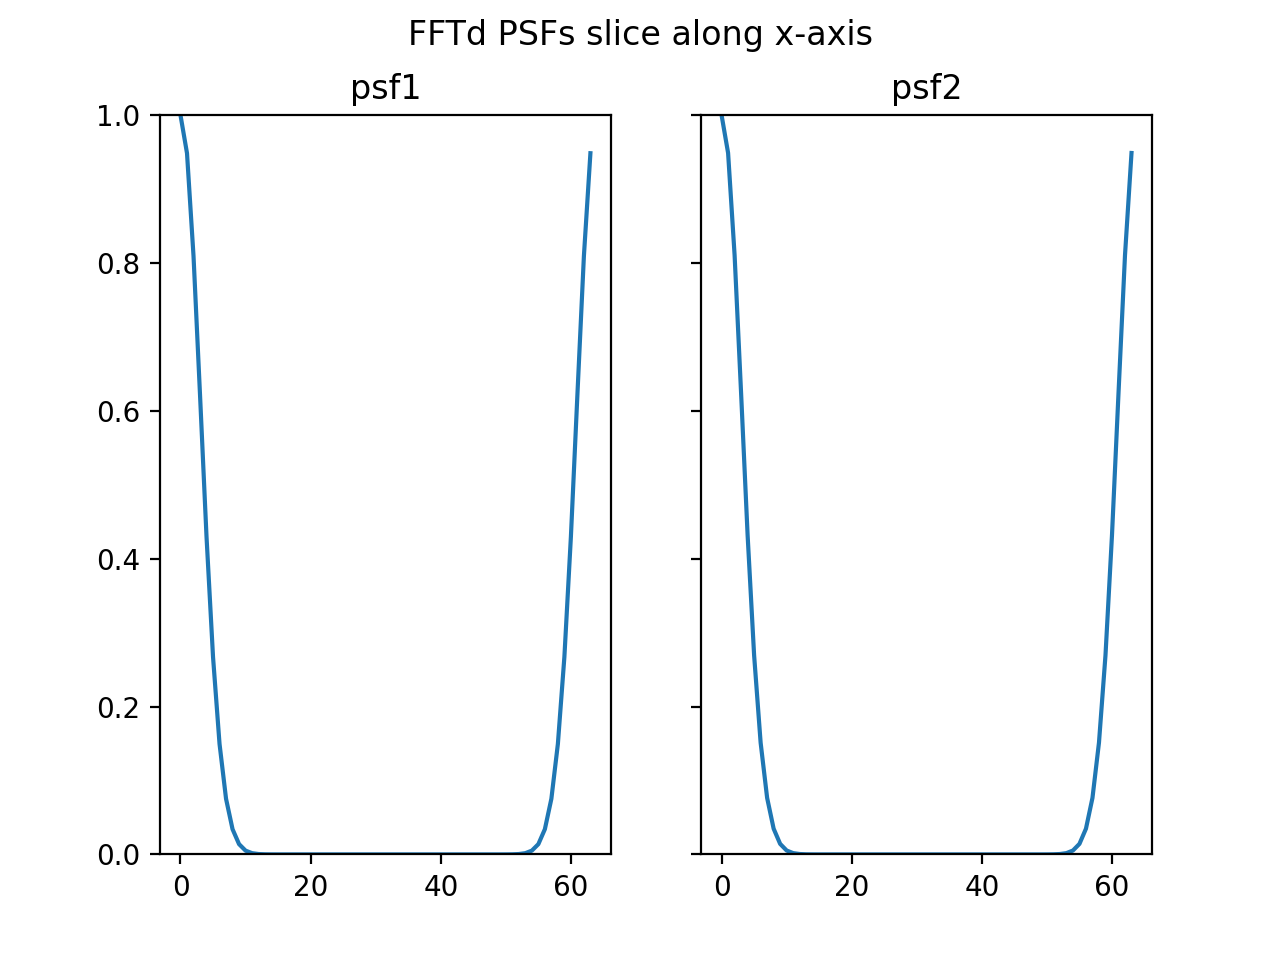

Text(0.5, 0.98, 'FFTd PSFs slice along x-axis')

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(psf1.real[0])
ax1.set_title("psf1")
cs = ax2.plot(psf2.real[0])
ax2.set_title("psf2")
ax1.set_ylim(0, 1.)
fig.suptitle("FFTd PSFs slice along x-axis")

In [8]:
# Handling zero division - not a good approach to replace them with zero...
fmK = np.zeros(psf1.shape, dtype=np.complex)
fltZ = psf2 != 0.
print("Number of zero pixels:", np.sum(~fltZ))
fmK[fltZ] = psf1[fltZ]/psf2[fltZ]

Number of zero pixels: 0


<IPython.core.display.Javascript object>


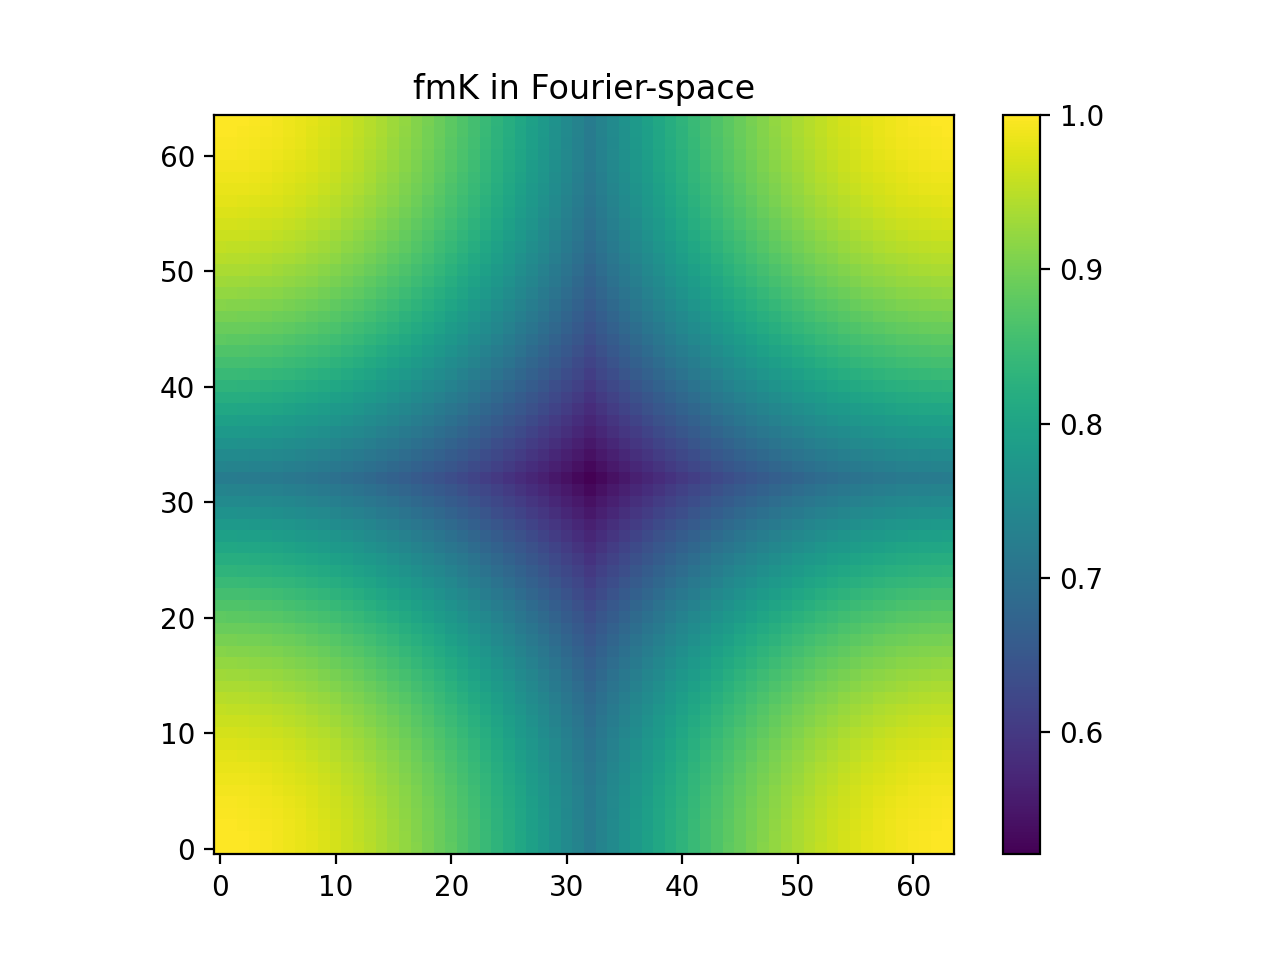

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
cs = ax1.imshow(fmK.real, origin='lower', interpolation='none')
ax1.set_title("fmK in Fourier-space")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


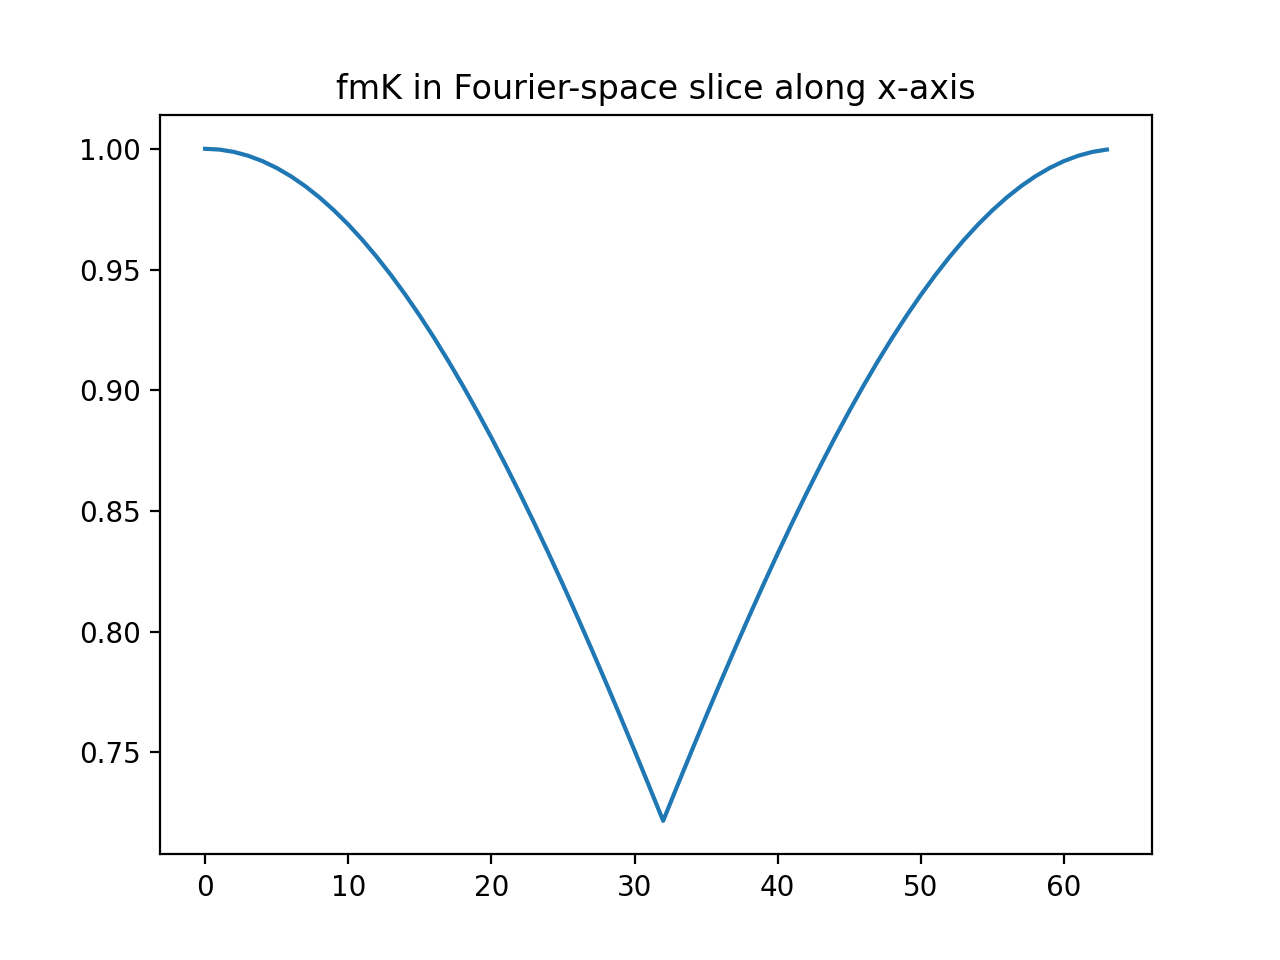

Text(0.5, 1.0, 'fmK in Fourier-space slice along x-axis')

In [10]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(fmK.real[0])
ax1.set_title("fmK in Fourier-space slice along x-axis")
#ax1.set_ylim(0,1.)

In [11]:
mK = np.fft.ifft2(fmK)
mK = mK.real

<IPython.core.display.Javascript object>


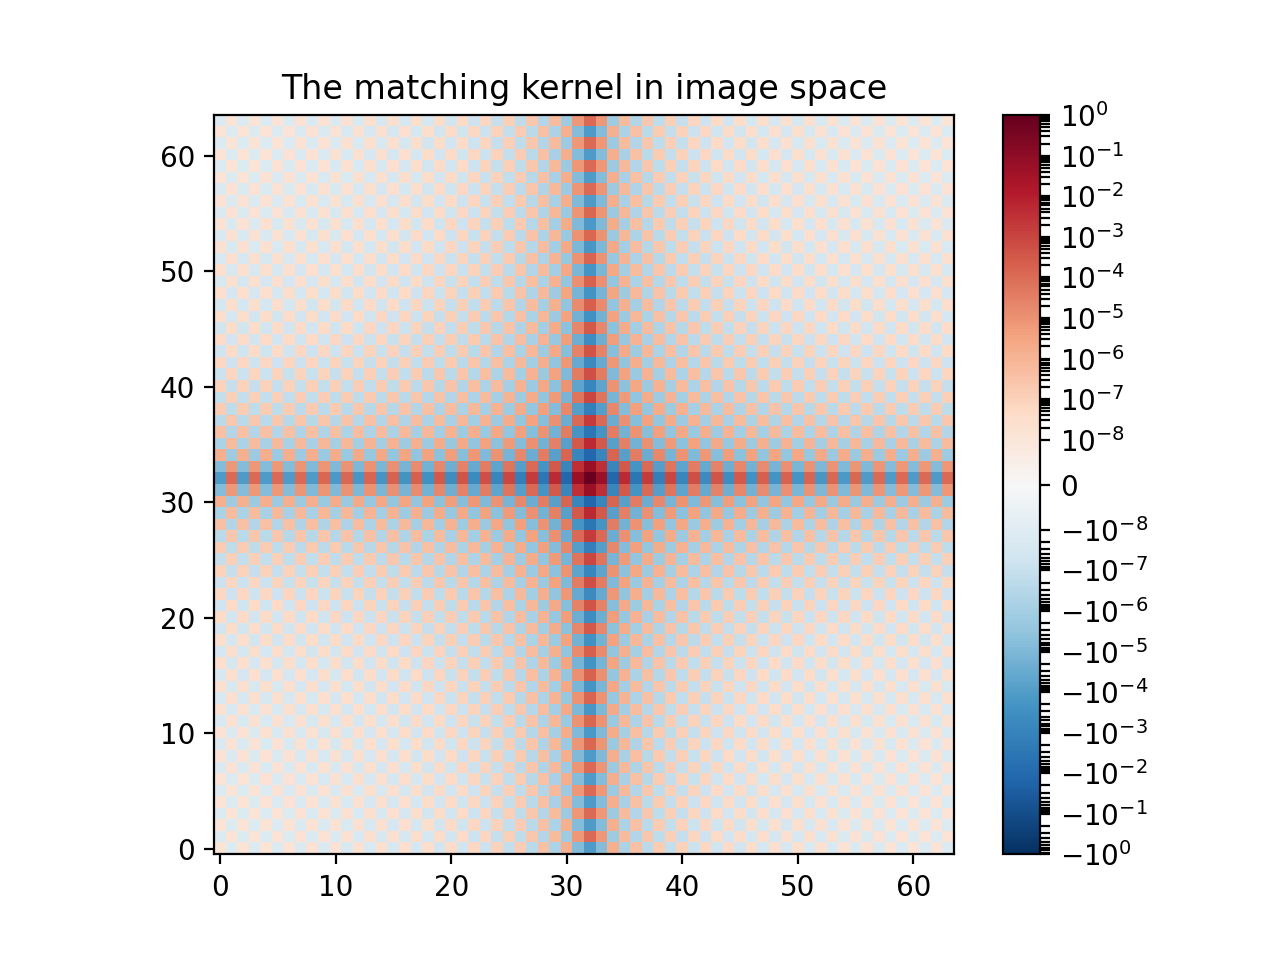

In [12]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
P2 = task.padCenterOriginArray(mK, (N, N), useInverse=True)
cs = ax1.imshow(P2, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("The matching kernel in image space")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


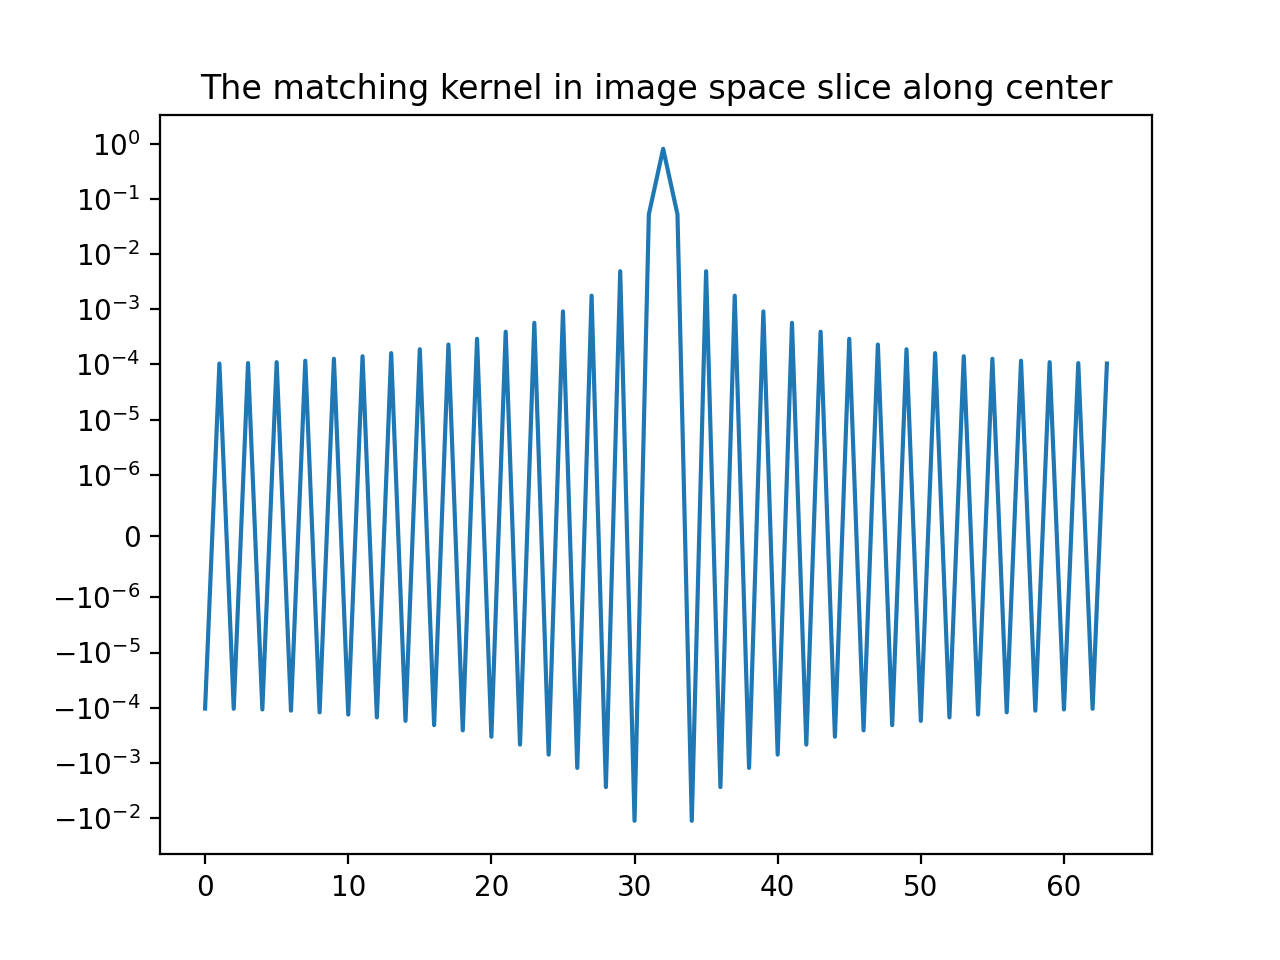

In [13]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(P2[32])
ax1.set_title("The matching kernel in image space slice along center")
ax1.set_yscale("symlog", linthresh=1e-6)

<IPython.core.display.Javascript object>


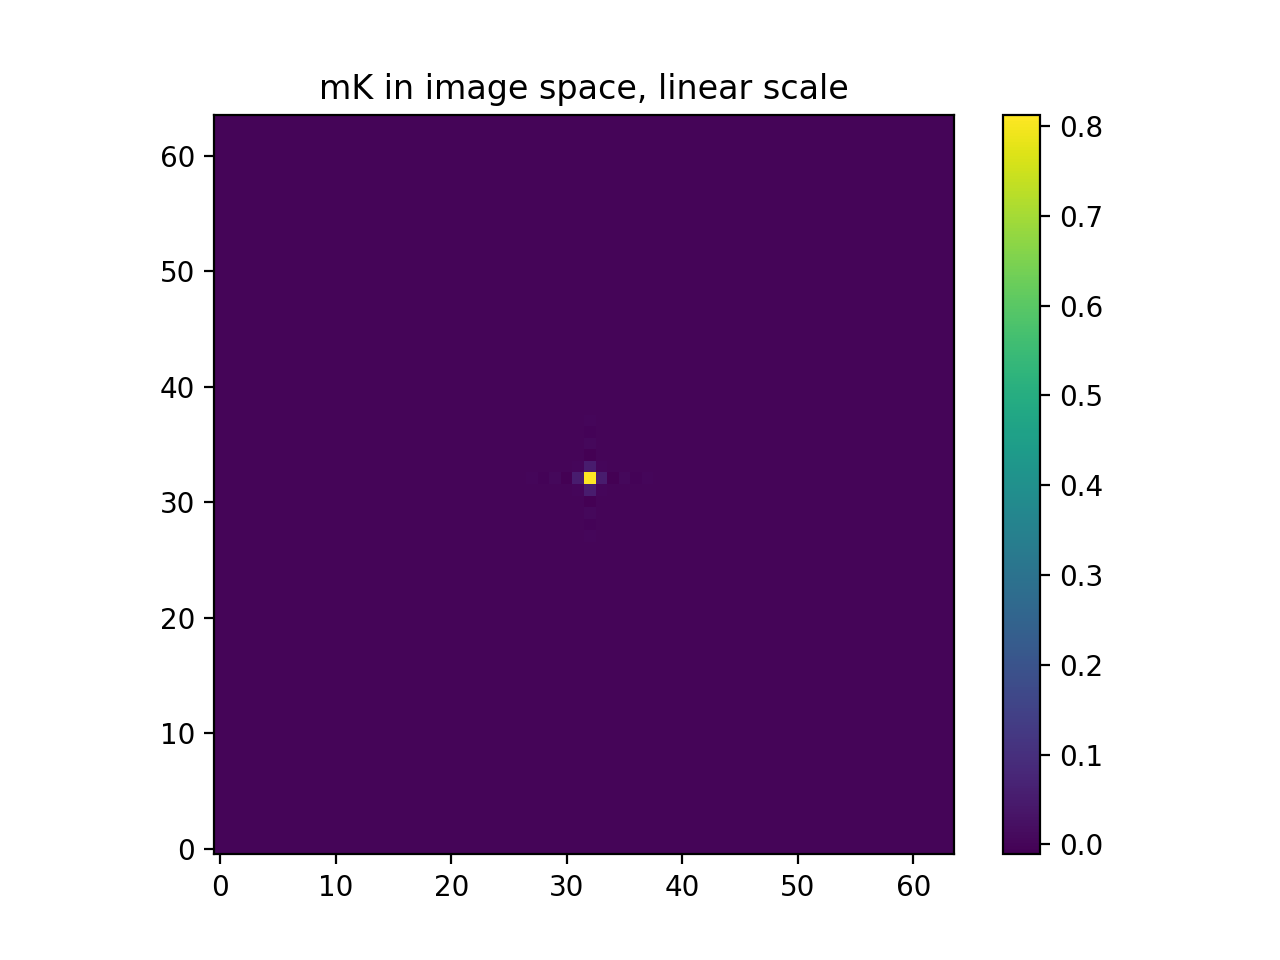

In [14]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
P2 = task.padCenterOriginArray(mK, (N, N), useInverse=True)
cs = ax1.imshow(P2, origin='lower', interpolation='none')
ax1.set_title("mK in image space, linear scale")
fig.colorbar(cs)

No shift in the input PSFs.

In [15]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


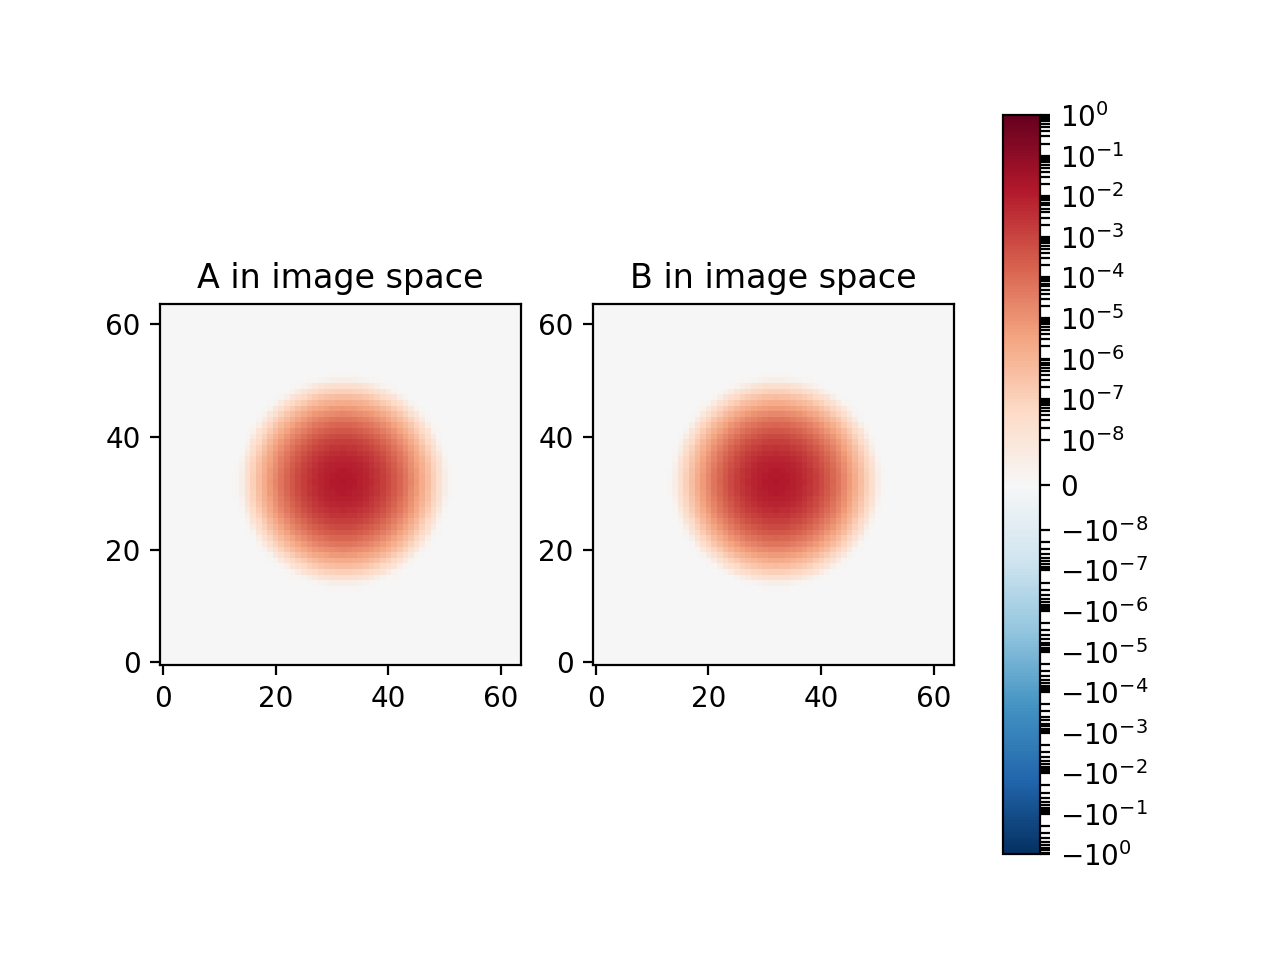

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


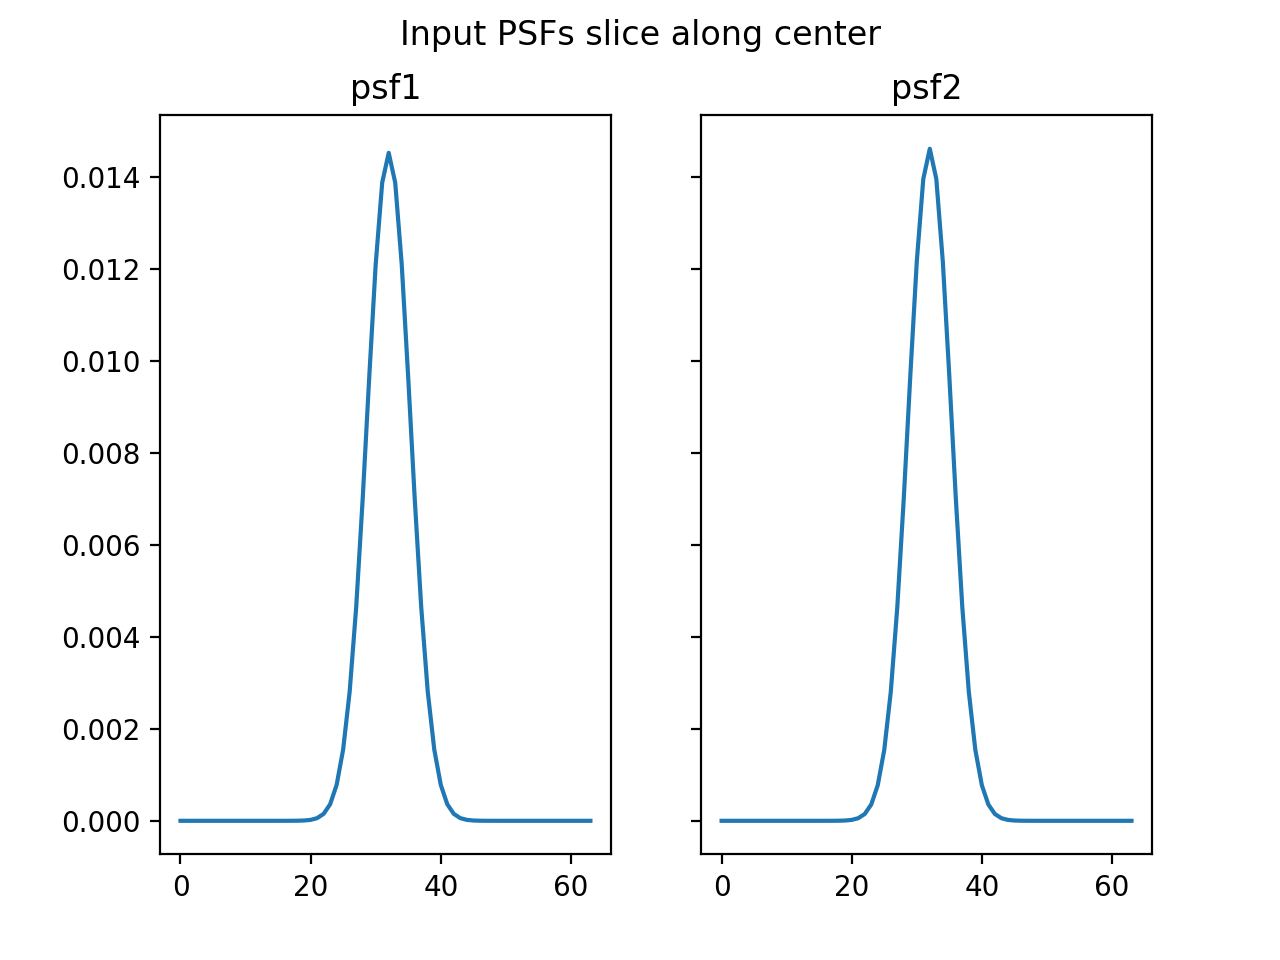

Text(0.5, 0.98, 'Input PSFs slice along center')

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [18]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


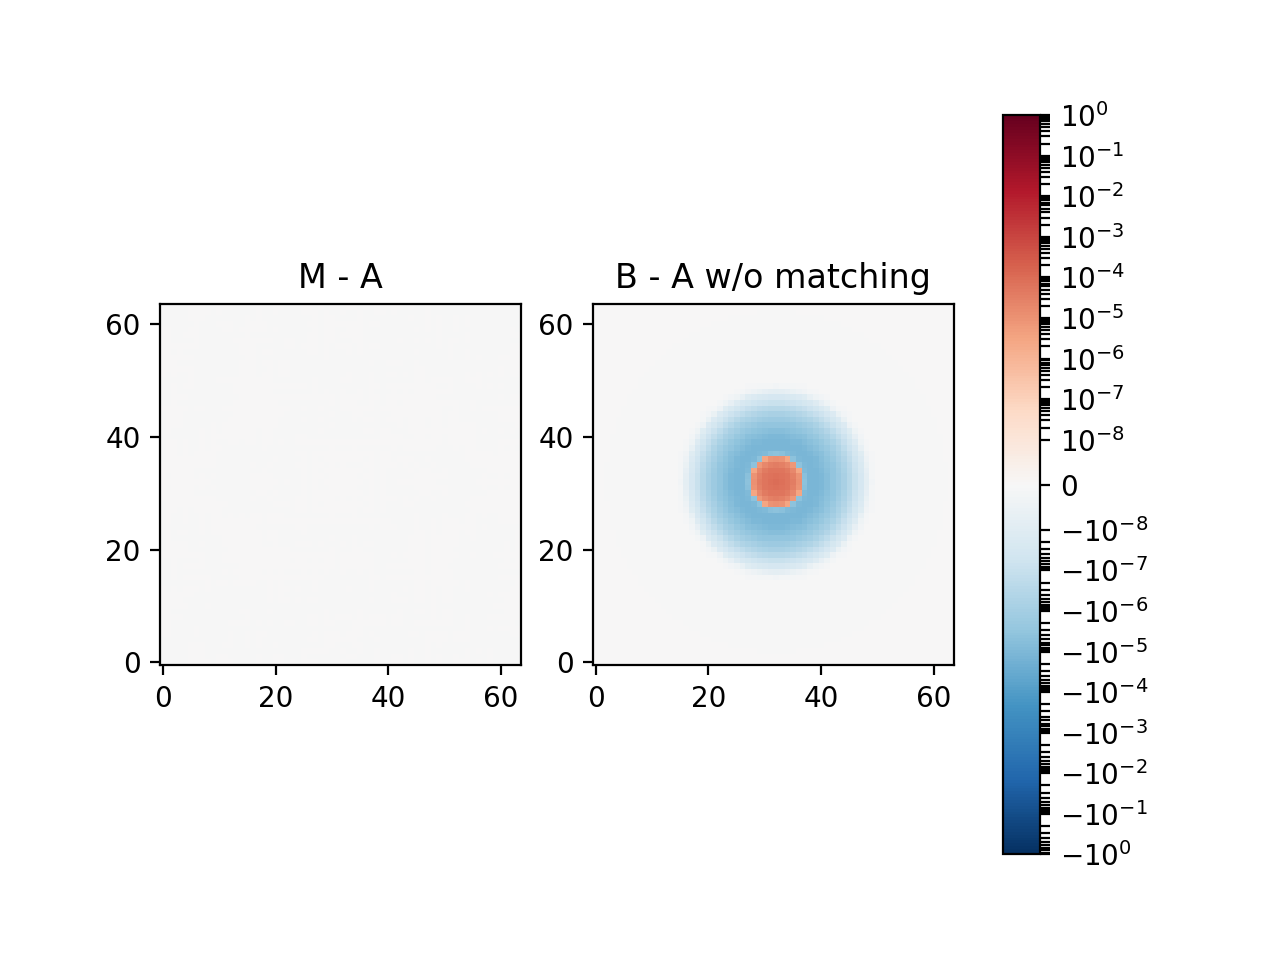

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


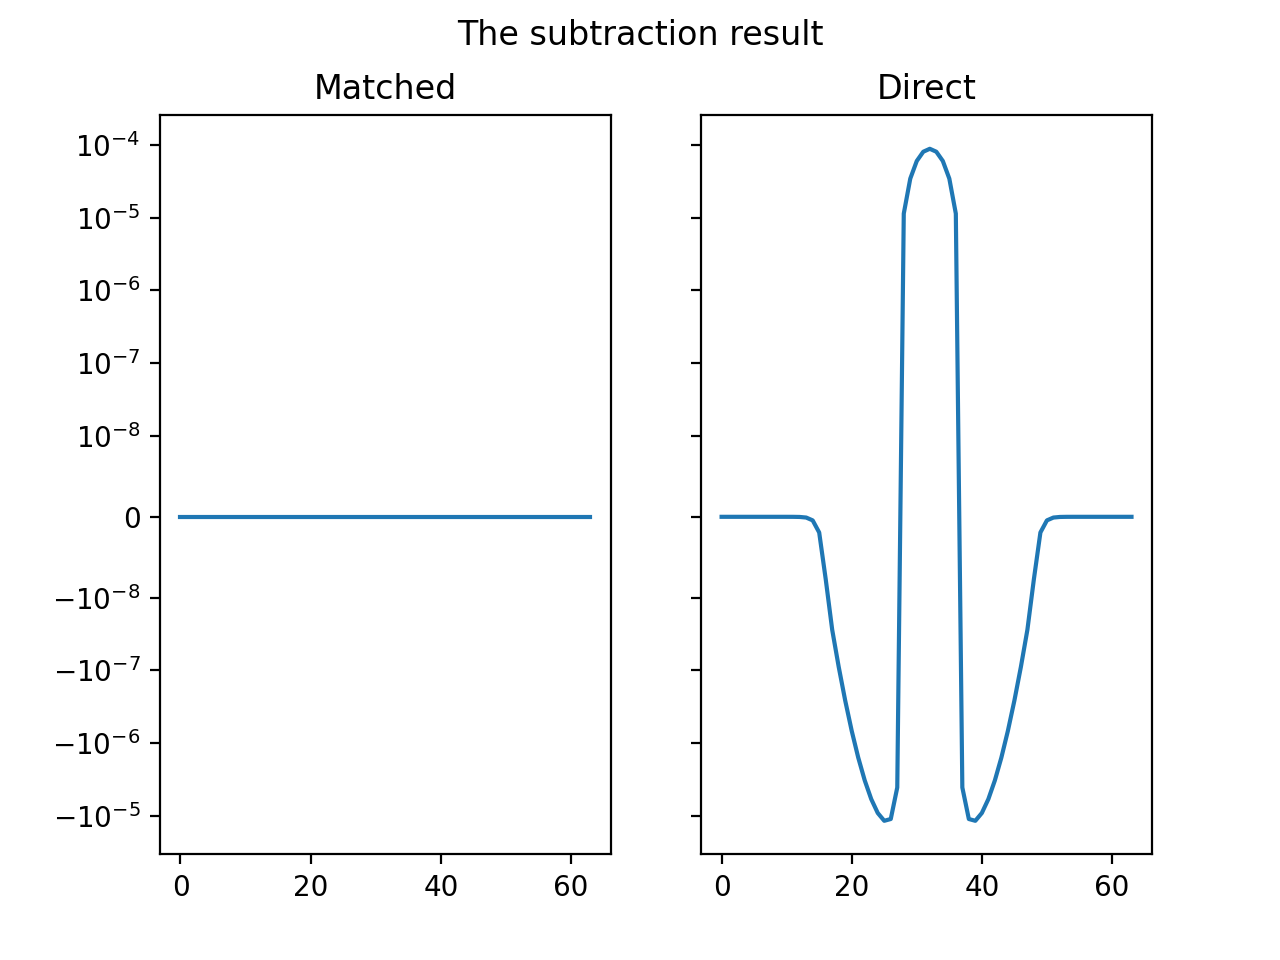

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-8)

-----------

Shift inputs by 0.1 pixel (in both direction)

In [21]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
B = scipy.ndimage.shift(B, 0.1, mode='constant')

pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


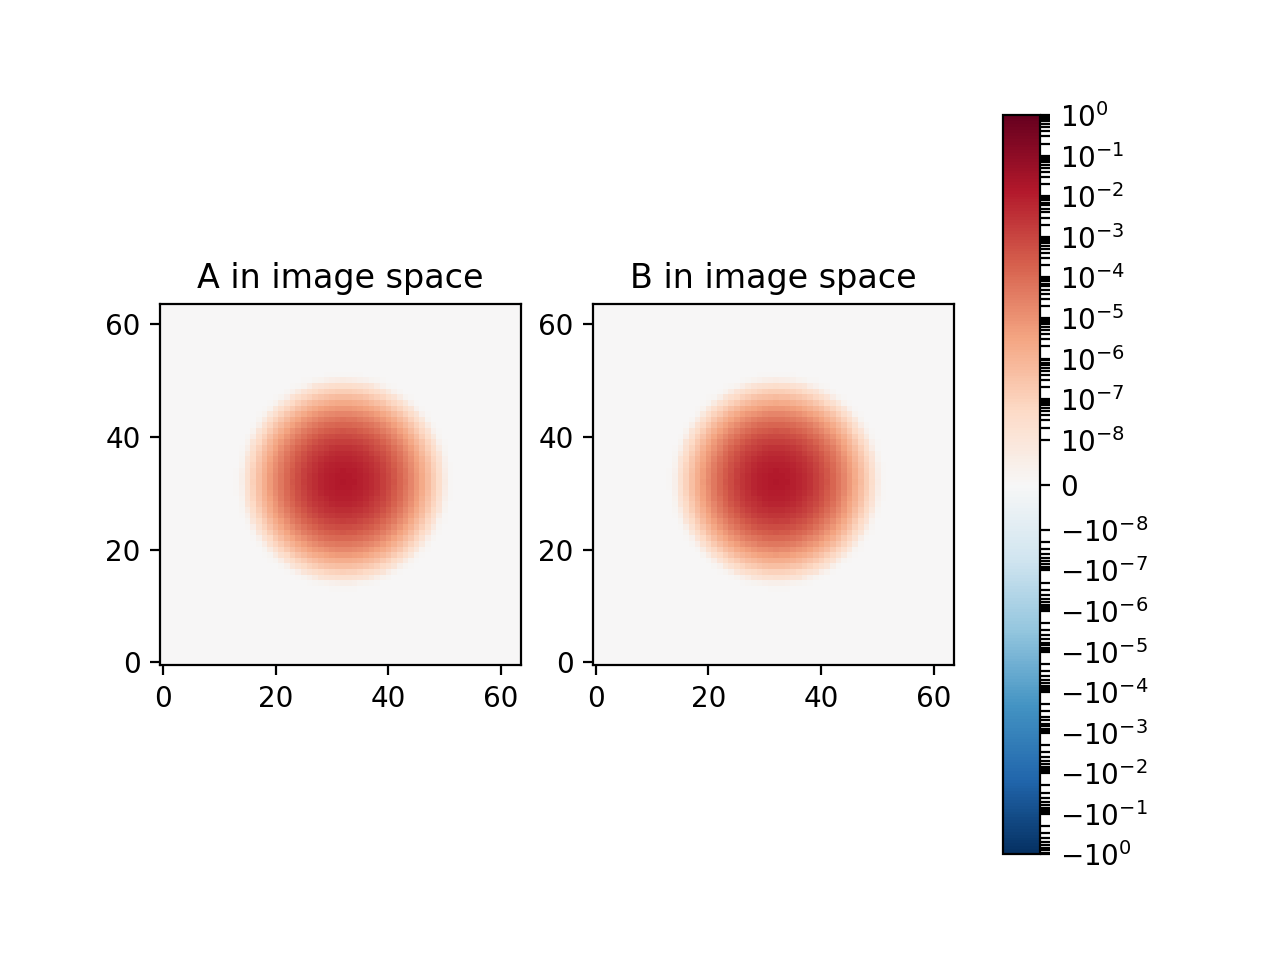

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


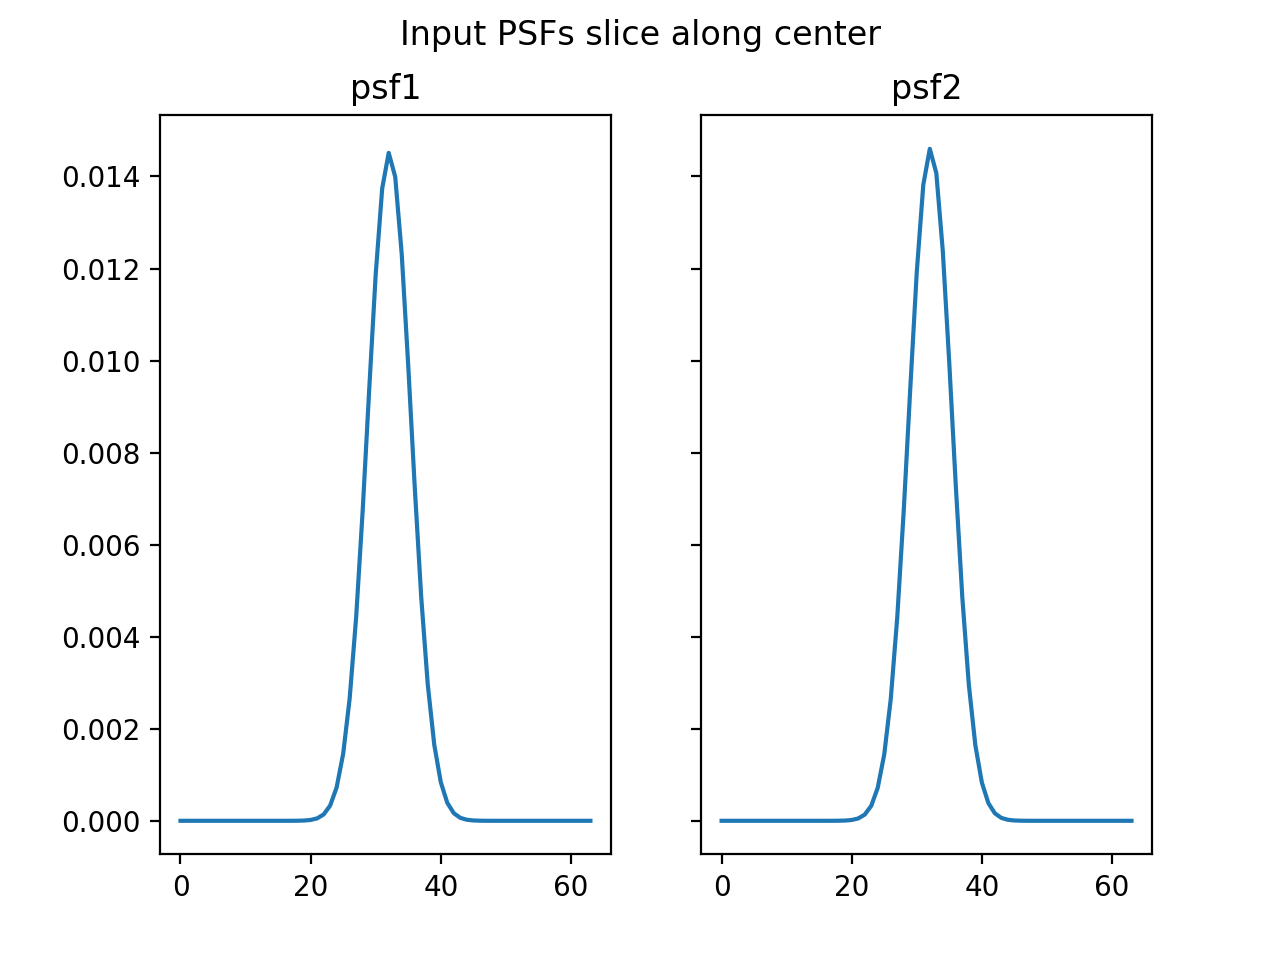

Text(0.5, 0.98, 'Input PSFs slice along center')

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [24]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


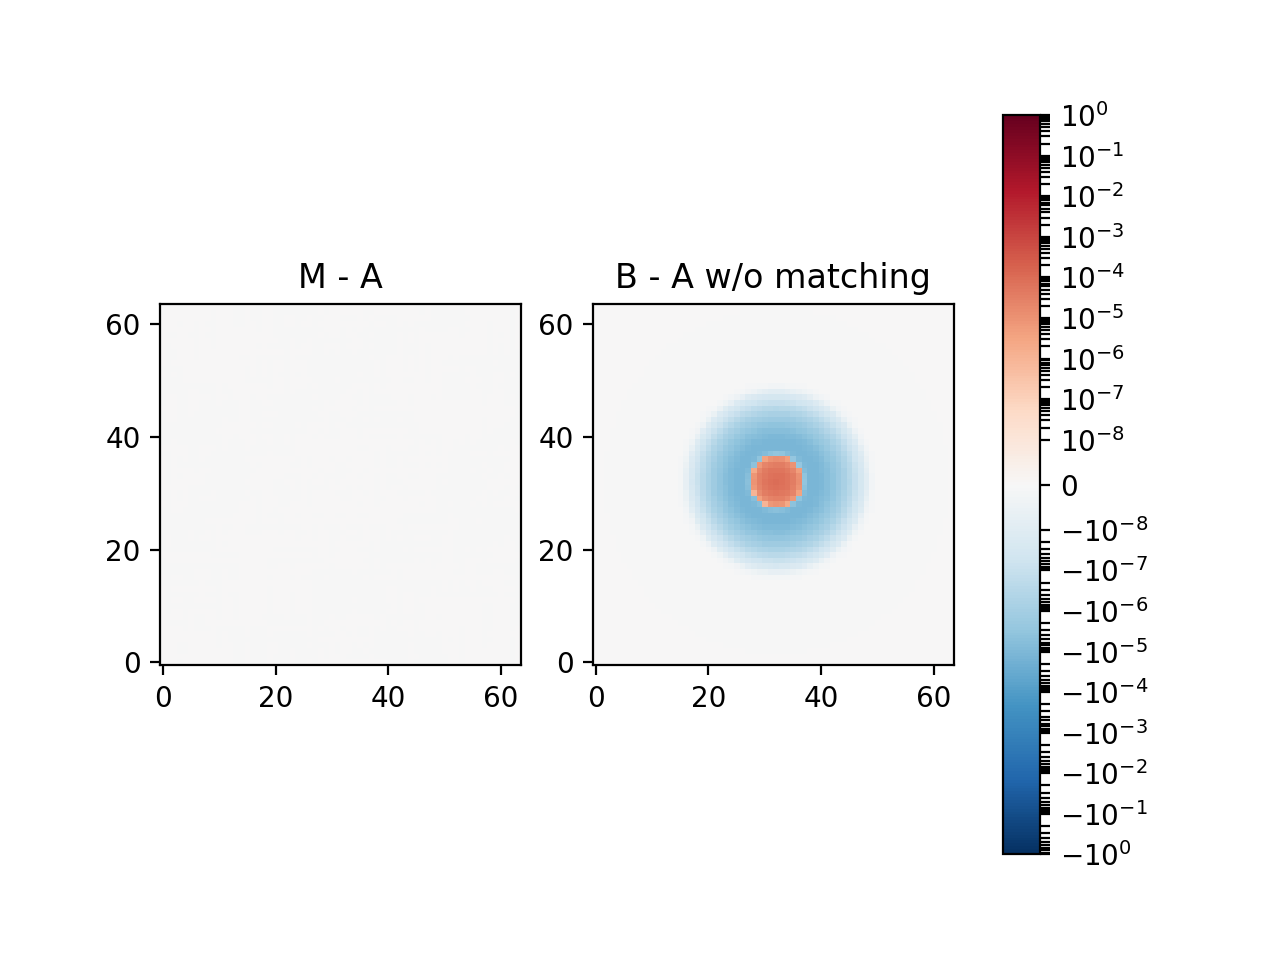

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


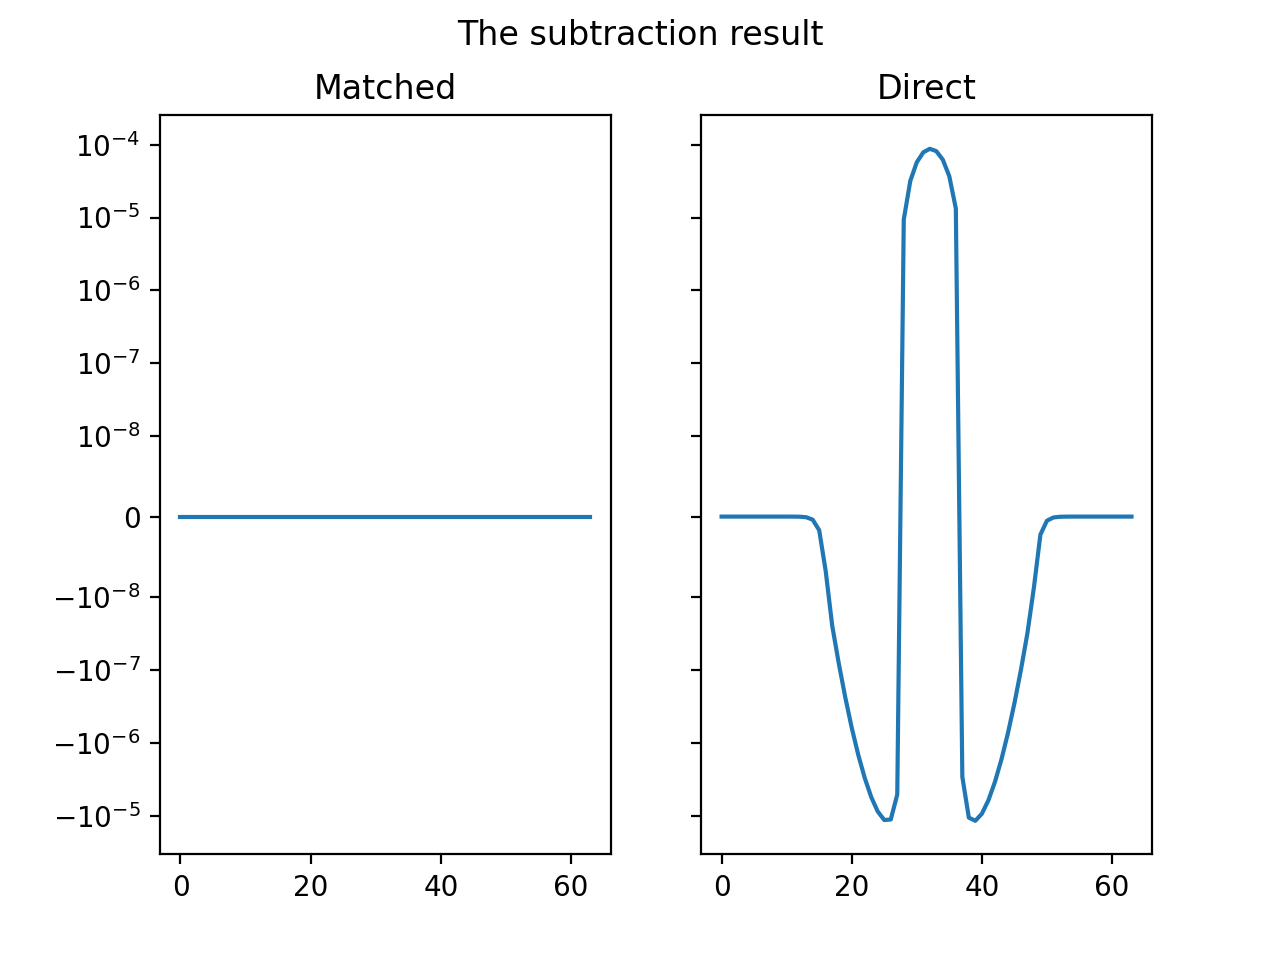

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-8)

------

One input is saturated (the PSF has edges).

In [27]:
A = calculate2dGaussianArray(N, N, wSig1)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
A /= np.sum(A)
B = calculate2dGaussianArray(N, N, wSig2)
B = scipy.ndimage.shift(B, 0.1, mode='constant')
thr = np.max(B) * 0.5
flt = B>thr
B[flt] = thr
# If the normalization is before the cut, the 2nd input won't be normalized to the same flux
B /= np.sum(B)  
pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


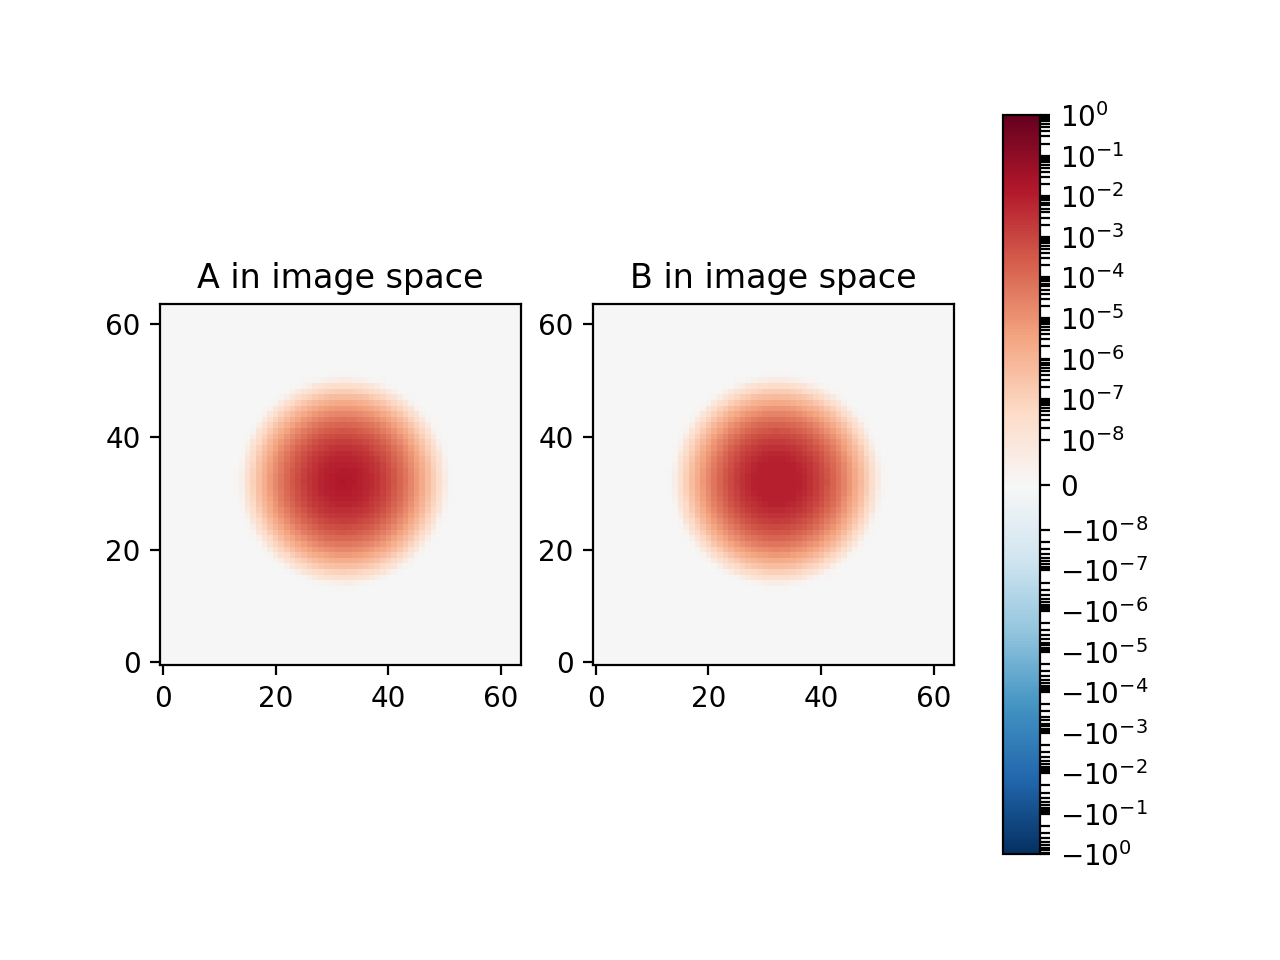

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


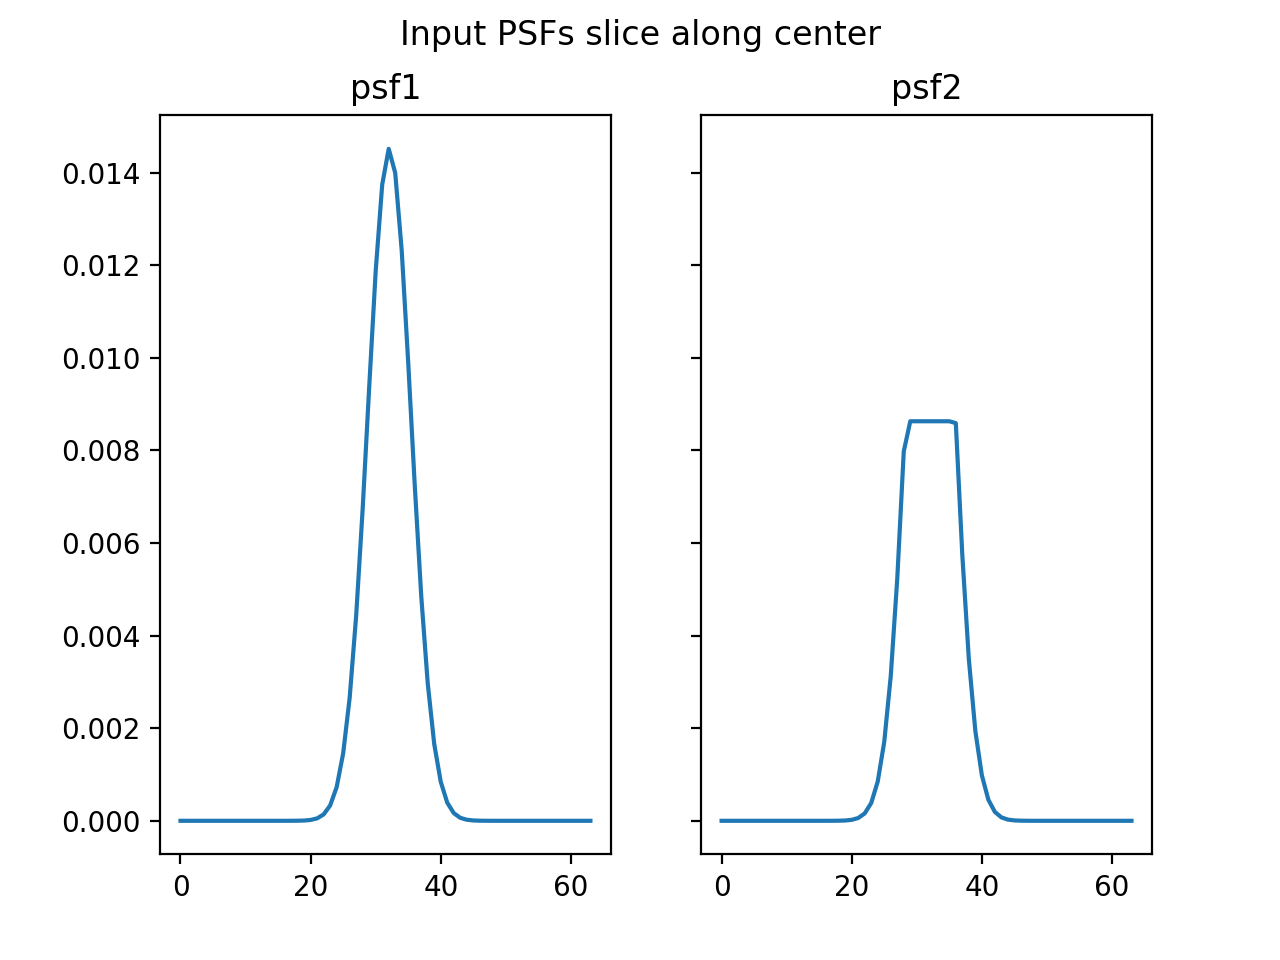

Text(0.5, 0.98, 'Input PSFs slice along center')

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [30]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


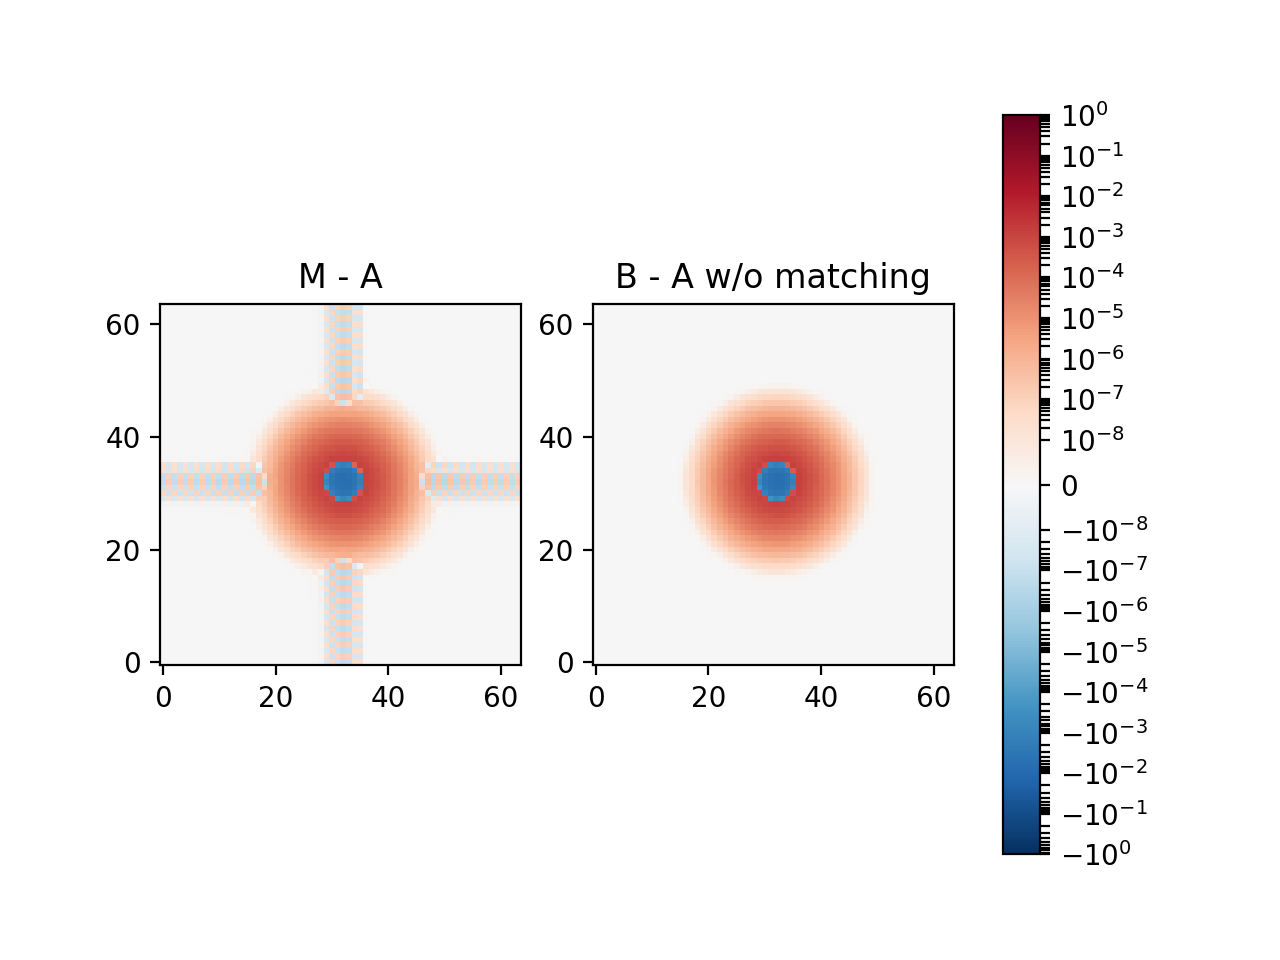

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


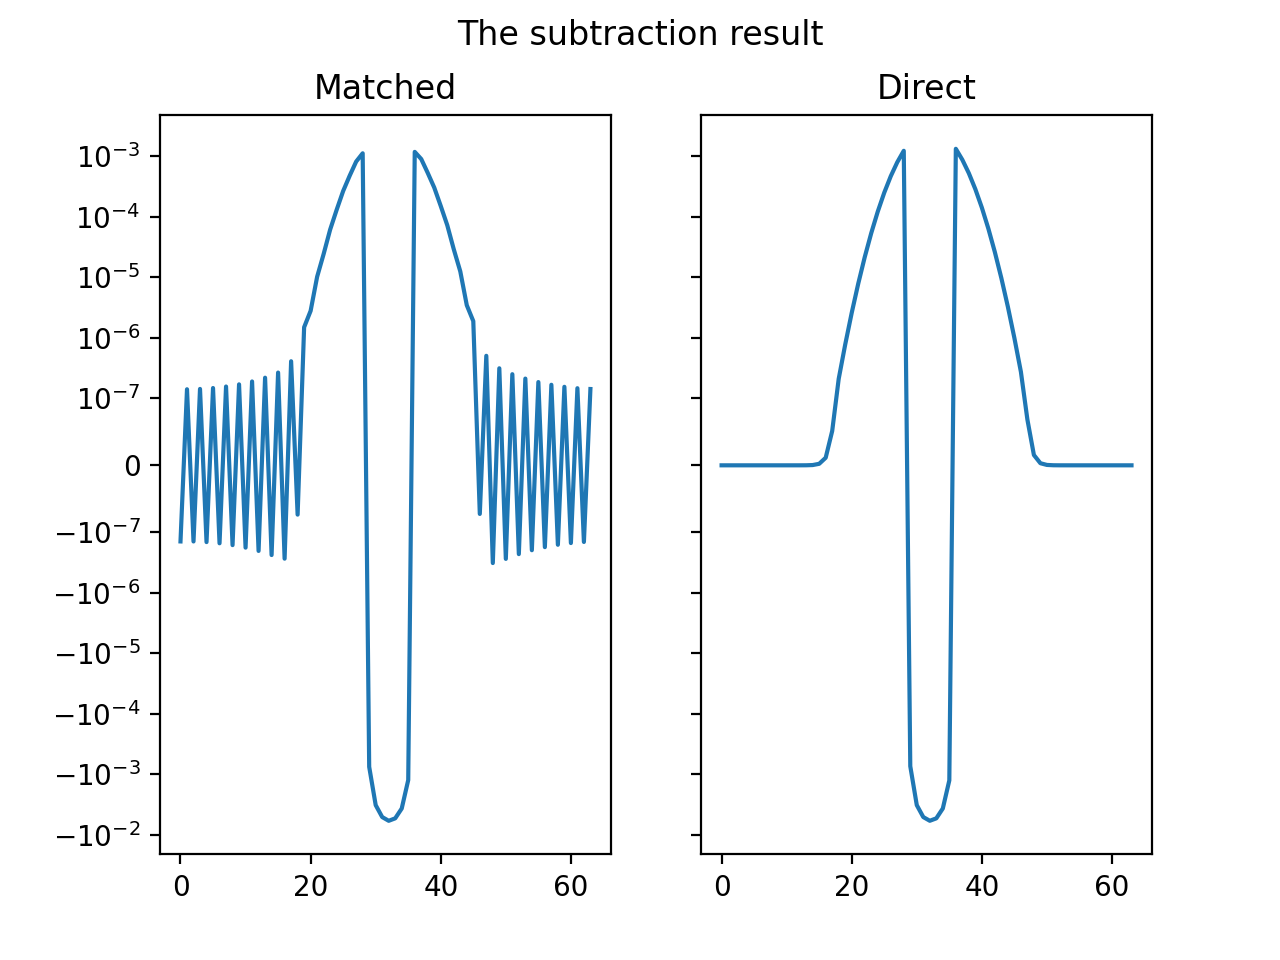

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-7)

-----

Centroid error of 0.01 pixel.

In [33]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
A = scipy.ndimage.shift(A, 0.11, mode='constant')

pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


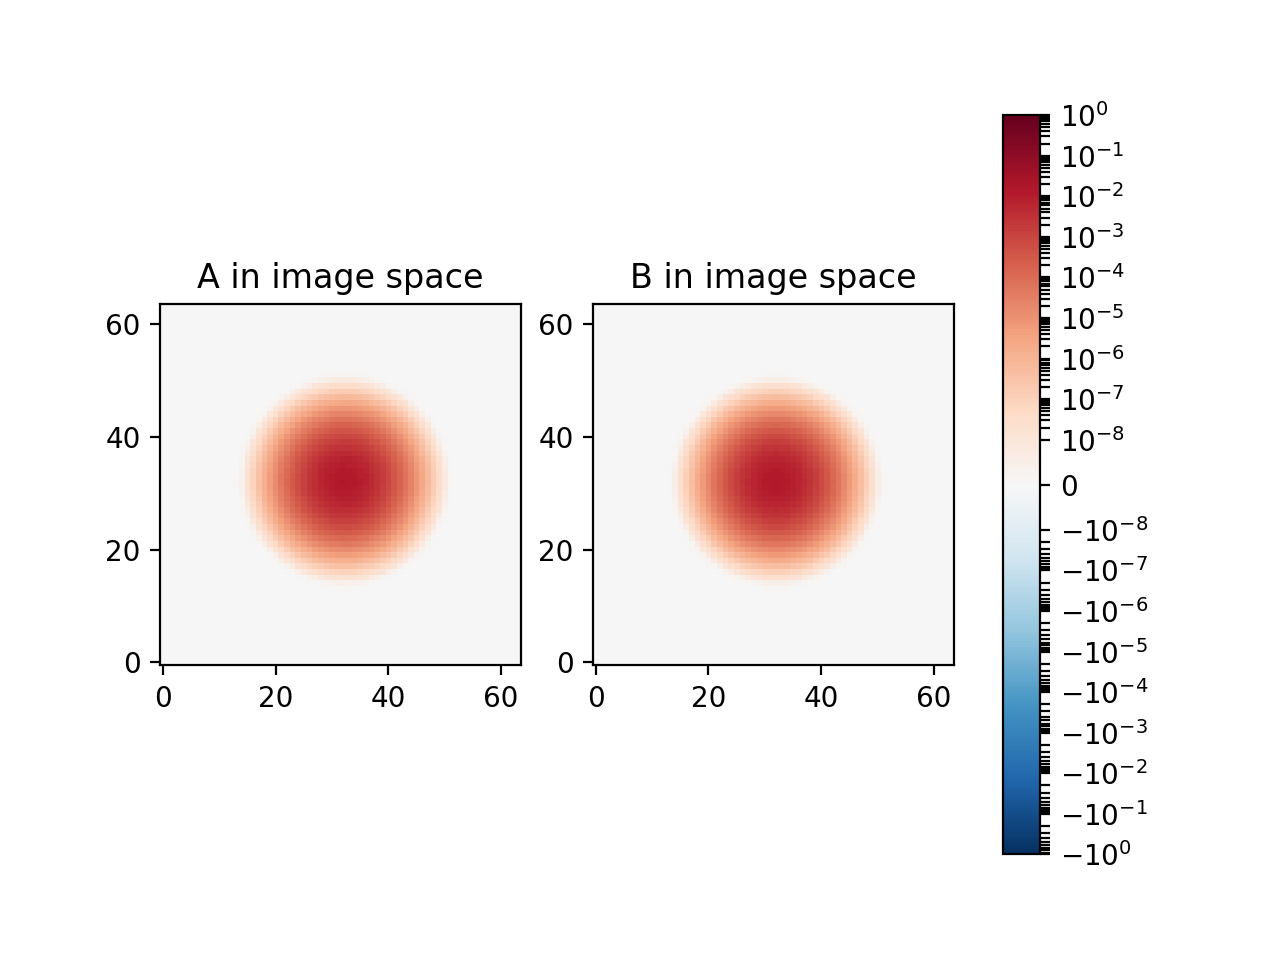

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<ipython-input-35-f6f474adcbb8>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)


<IPython.core.display.Javascript object>


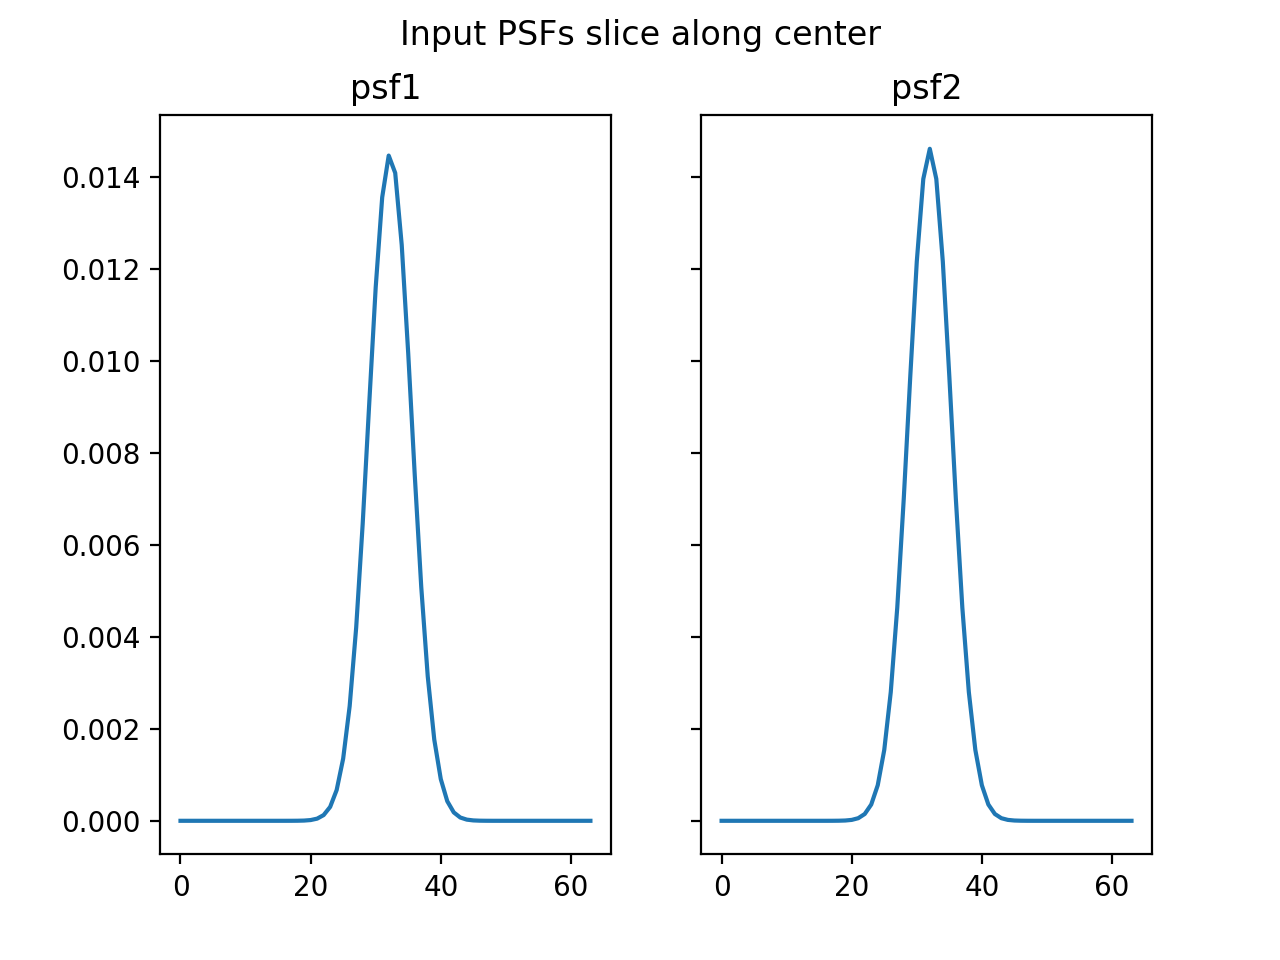

Text(0.5, 0.98, 'Input PSFs slice along center')

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [36]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


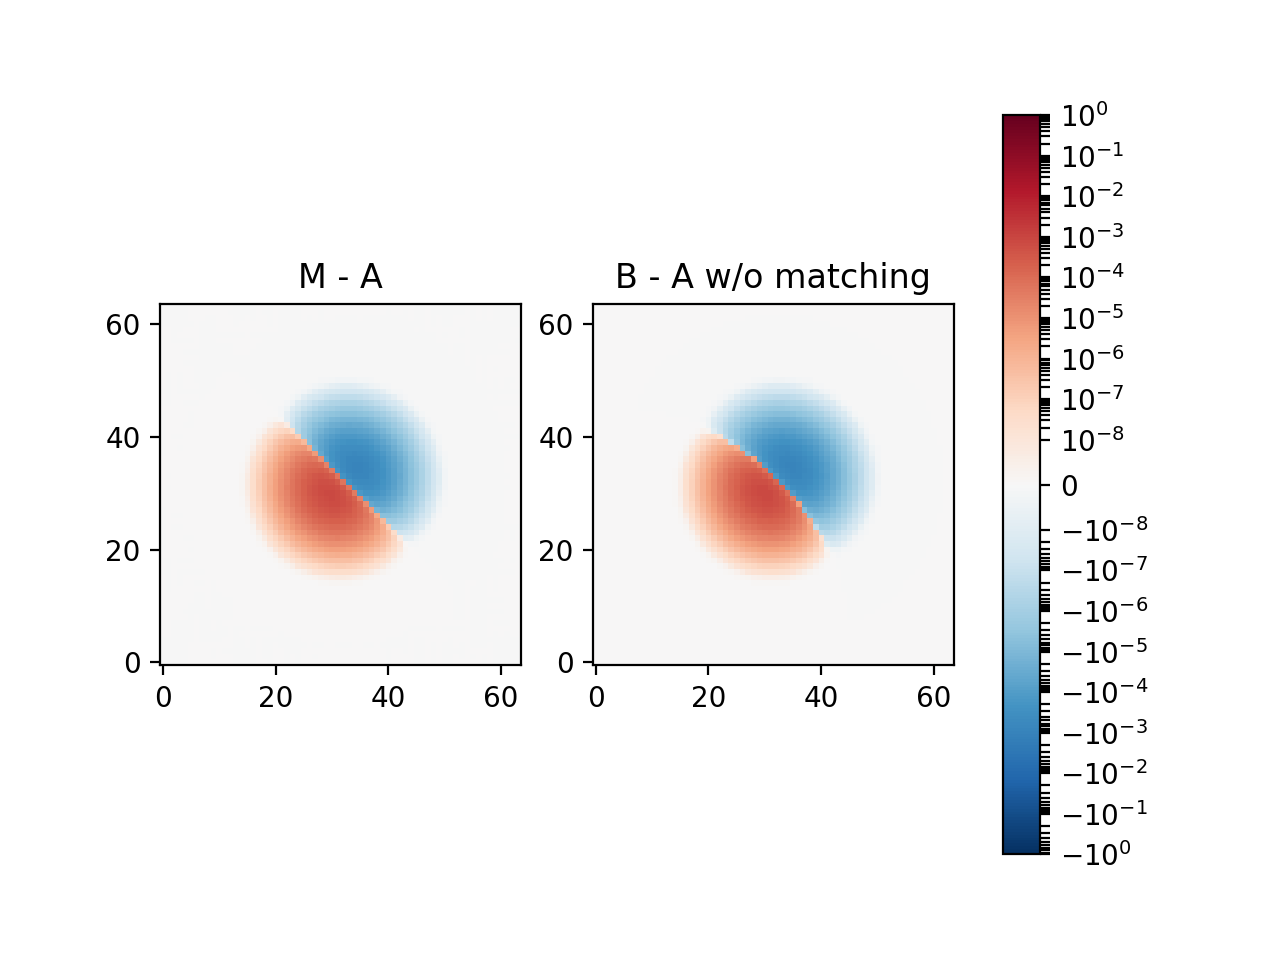

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


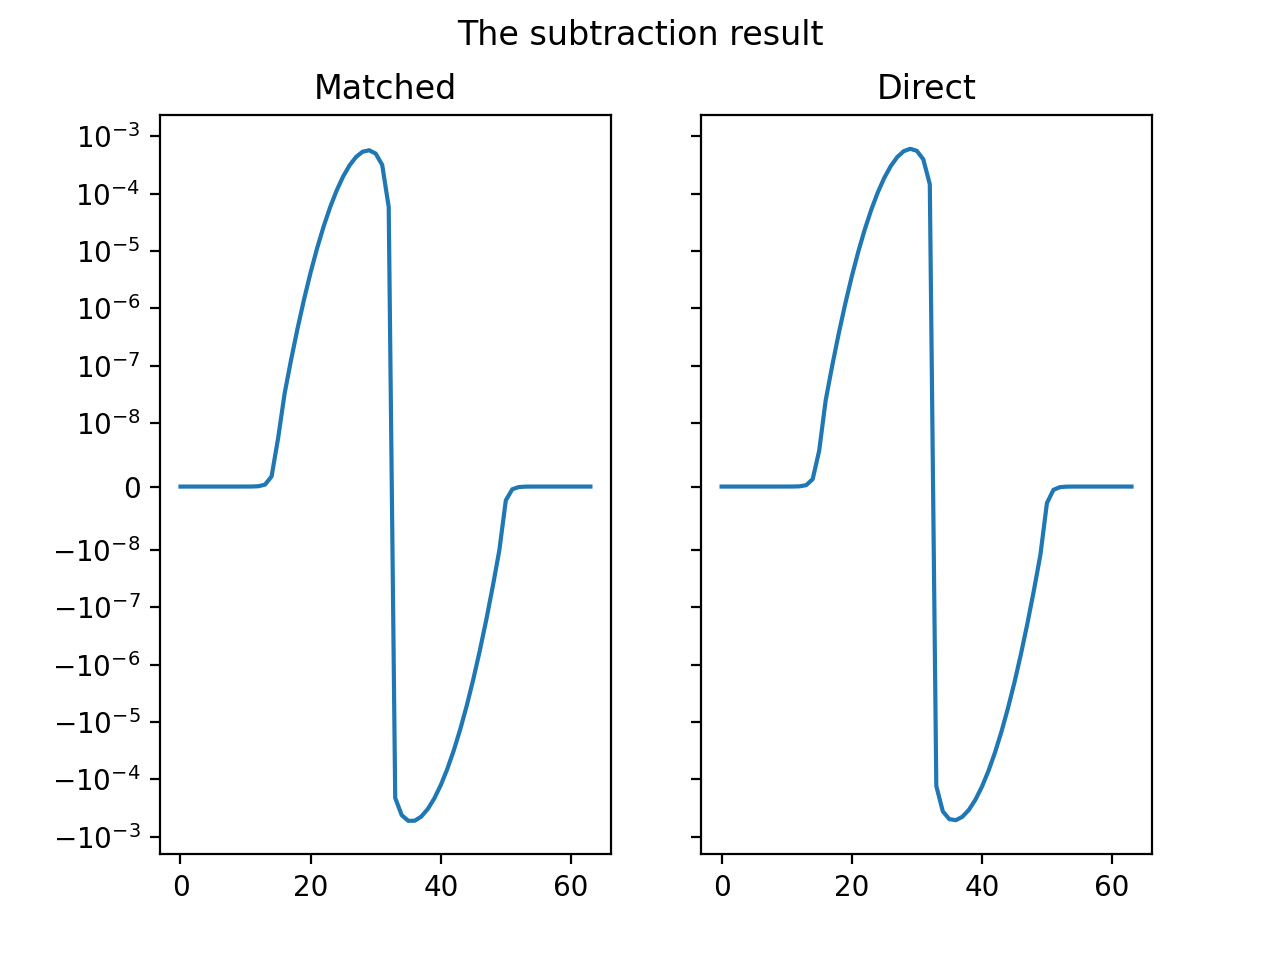

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-8)

-----

## Undersampled inputs

In [39]:
wSig1 = 0.61
wSig2 = 0.6
N = 64
print("Matching kernel sigma:",np.sqrt(wSig1**2 - wSig2**2))

Matching kernel sigma: 0.11


In [40]:
# Approach 1: calculate the matching kernel from the FFTd inputs
# This adds the usual problem of not getting a reasonable value from the tails and must handle zero division, too
# But, it works surprisingly well for matching
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

In [41]:
# # Approach 2: calculate the matching kernel from directly Fourier space generated inputs
# # For the matching kernel calculation, produce the FFTs directly in Fourier space
# # This usually avoids zero division at this resolution, use this to avoid DFT tail noise 
# # when the inputs are well sampled
# # This does NOT produce aliasing. For undersampled inputs, use approach 1.
# psf1 = calculate2dGaussianArray(N, N, wSig1, inFrequencySpace=True, fftShift=True)
# psf2 = calculate2dGaussianArray(N, N, wSig2, inFrequencySpace=True, fftShift=True)

<IPython.core.display.Javascript object>


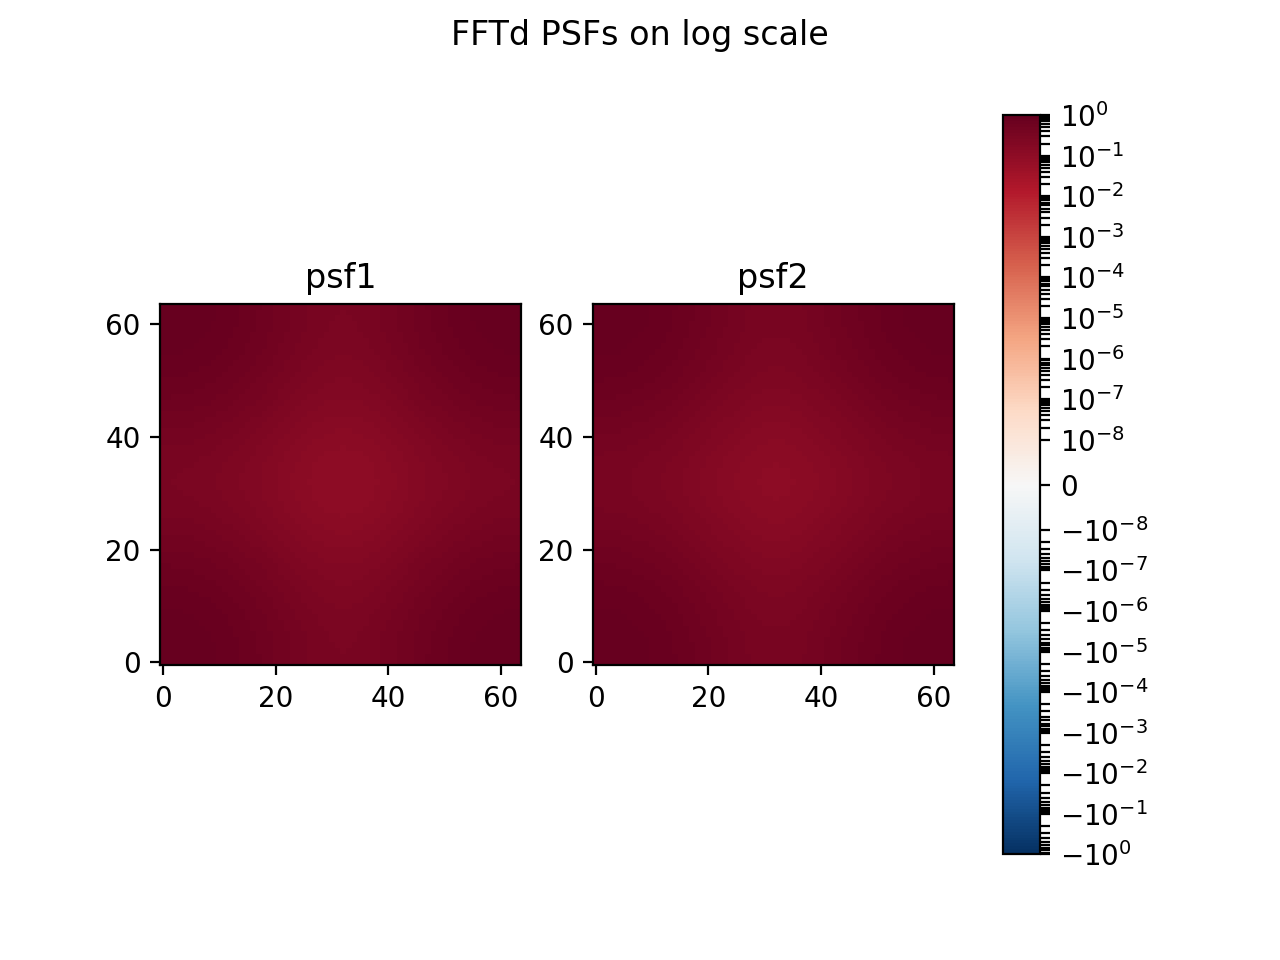

Text(0.5, 0.98, 'FFTd PSFs on log scale')

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(psf1.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("psf1")
cs = ax2.imshow(psf2.real, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1,vmax=1))
ax2.set_title("psf2")
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs on log scale")

<IPython.core.display.Javascript object>


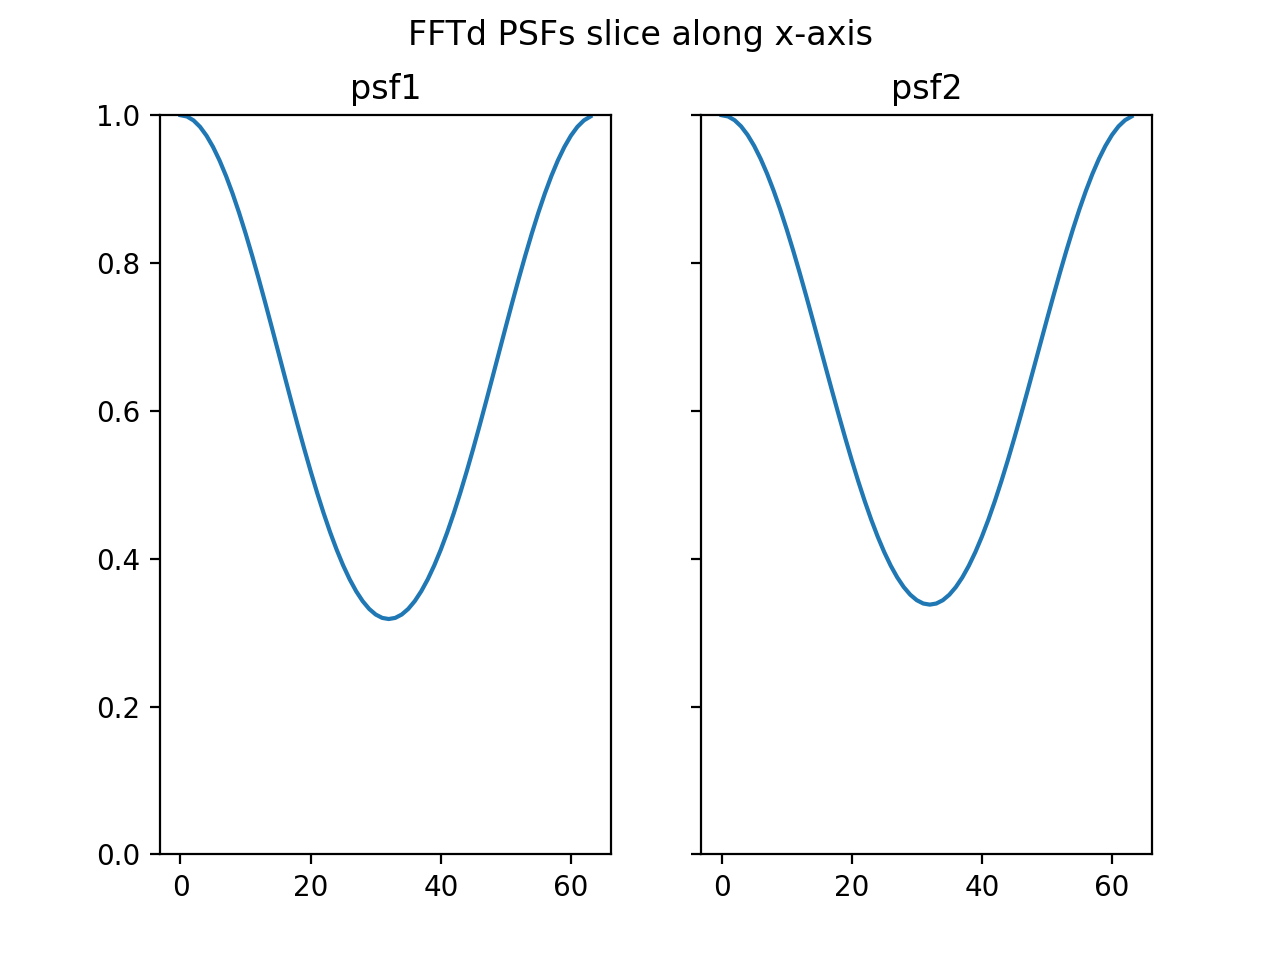

Text(0.5, 0.98, 'FFTd PSFs slice along x-axis')

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(psf1.real[0])
ax1.set_title("psf1")
cs = ax2.plot(psf2.real[0])
ax2.set_title("psf2")
ax1.set_ylim(0, 1.)
fig.suptitle("FFTd PSFs slice along x-axis")

In [44]:
# Handling zero division - not a good approach to replace them with zero...
fmK = np.zeros(psf1.shape, dtype=np.complex)
fltZ = psf2 != 0.
print("Number of zero pixels:", np.sum(~fltZ))
fmK[fltZ] = psf1[fltZ]/psf2[fltZ]

Number of zero pixels: 0


<IPython.core.display.Javascript object>


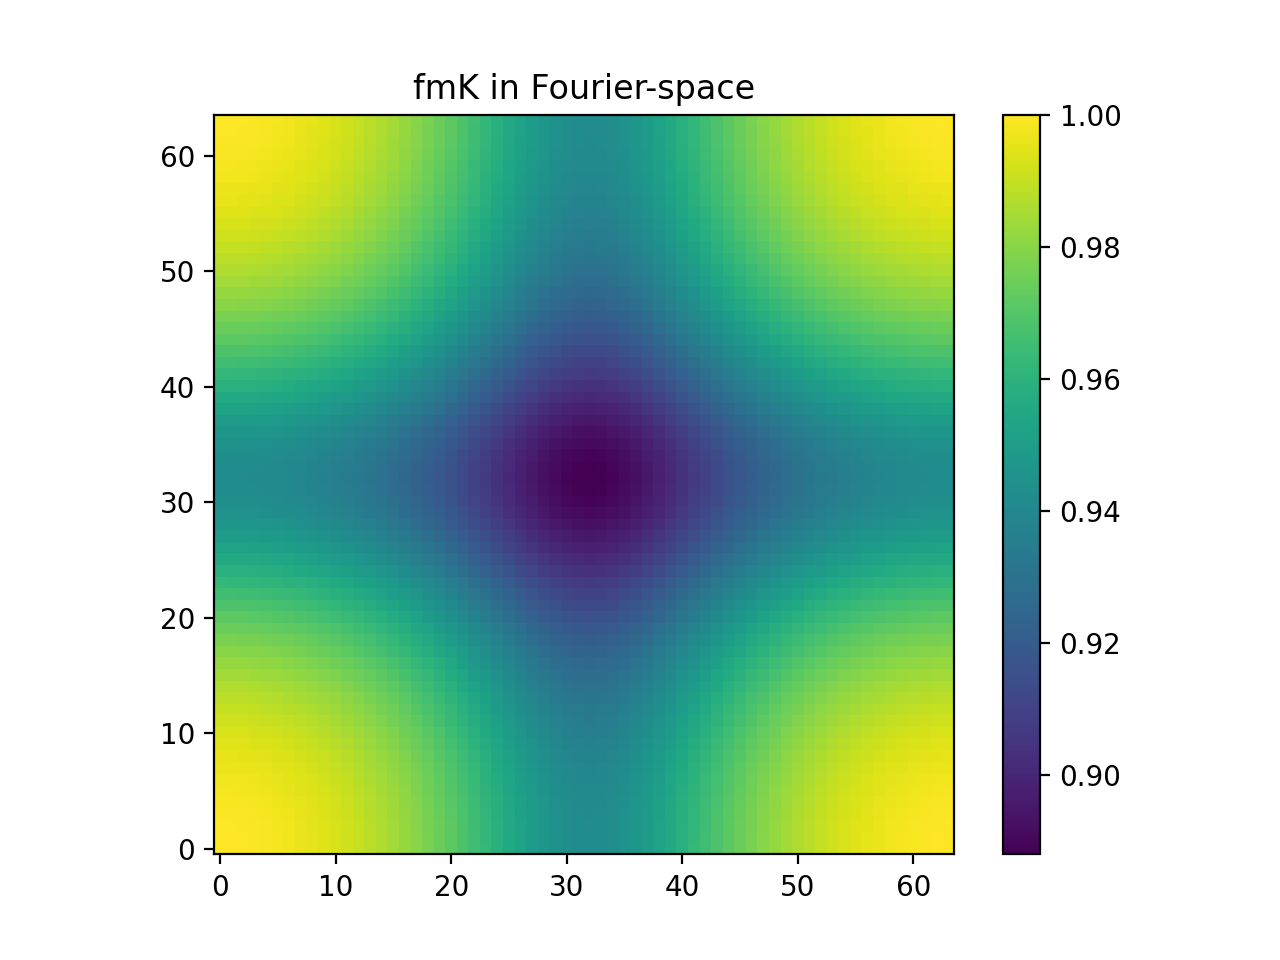

In [45]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
cs = ax1.imshow(fmK.real, origin='lower', interpolation='none')
ax1.set_title("fmK in Fourier-space")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


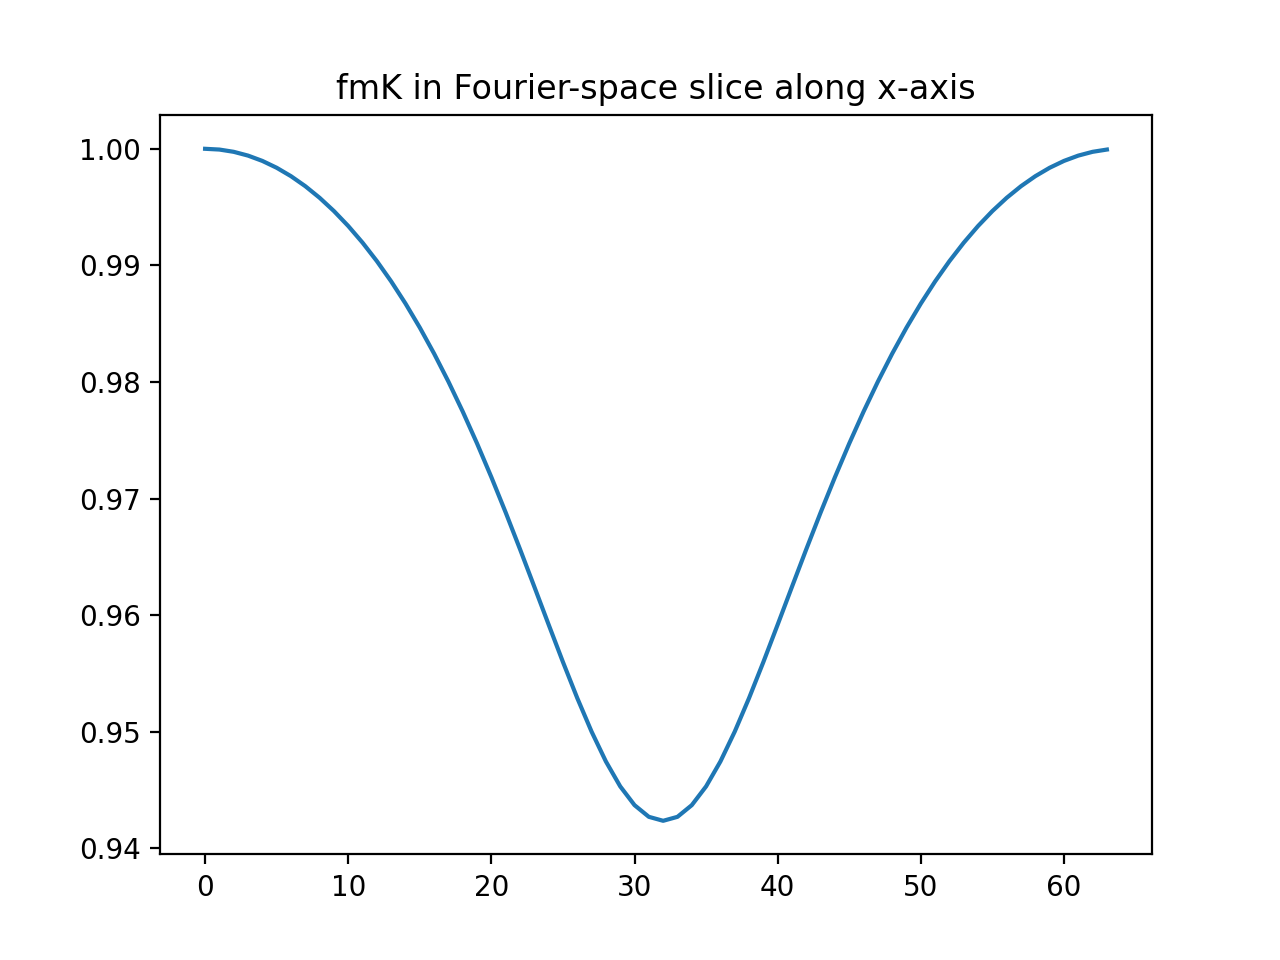

Text(0.5, 1.0, 'fmK in Fourier-space slice along x-axis')

In [46]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(fmK.real[0])
ax1.set_title("fmK in Fourier-space slice along x-axis")
#ax1.set_ylim(0,1.)

In [47]:
mK = np.fft.ifft2(fmK)
mK = mK.real

<IPython.core.display.Javascript object>


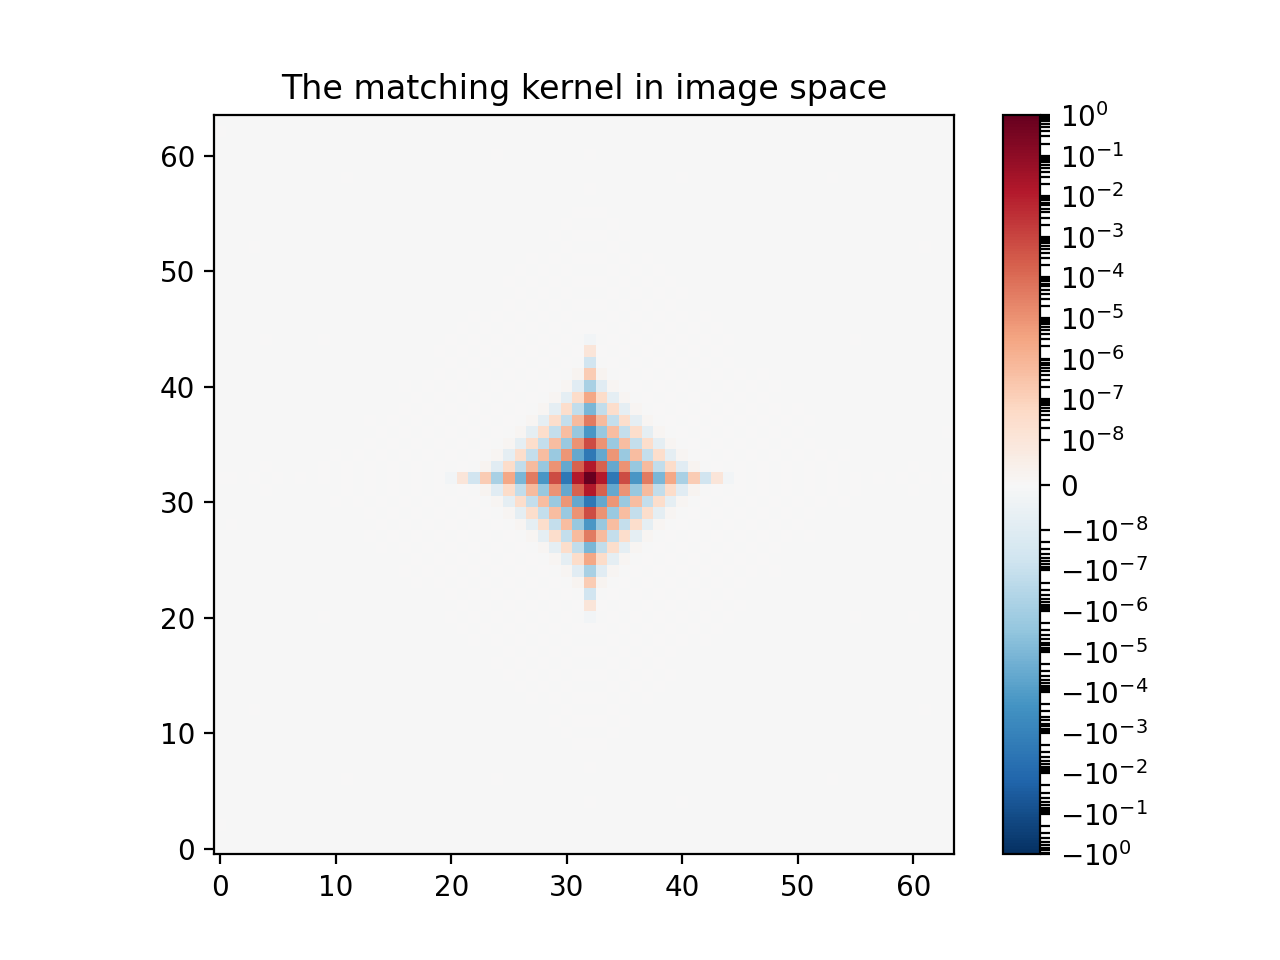

In [48]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
P2 = task.padCenterOriginArray(mK, (N, N), useInverse=True)
cs = ax1.imshow(P2, origin='lower', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("The matching kernel in image space")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


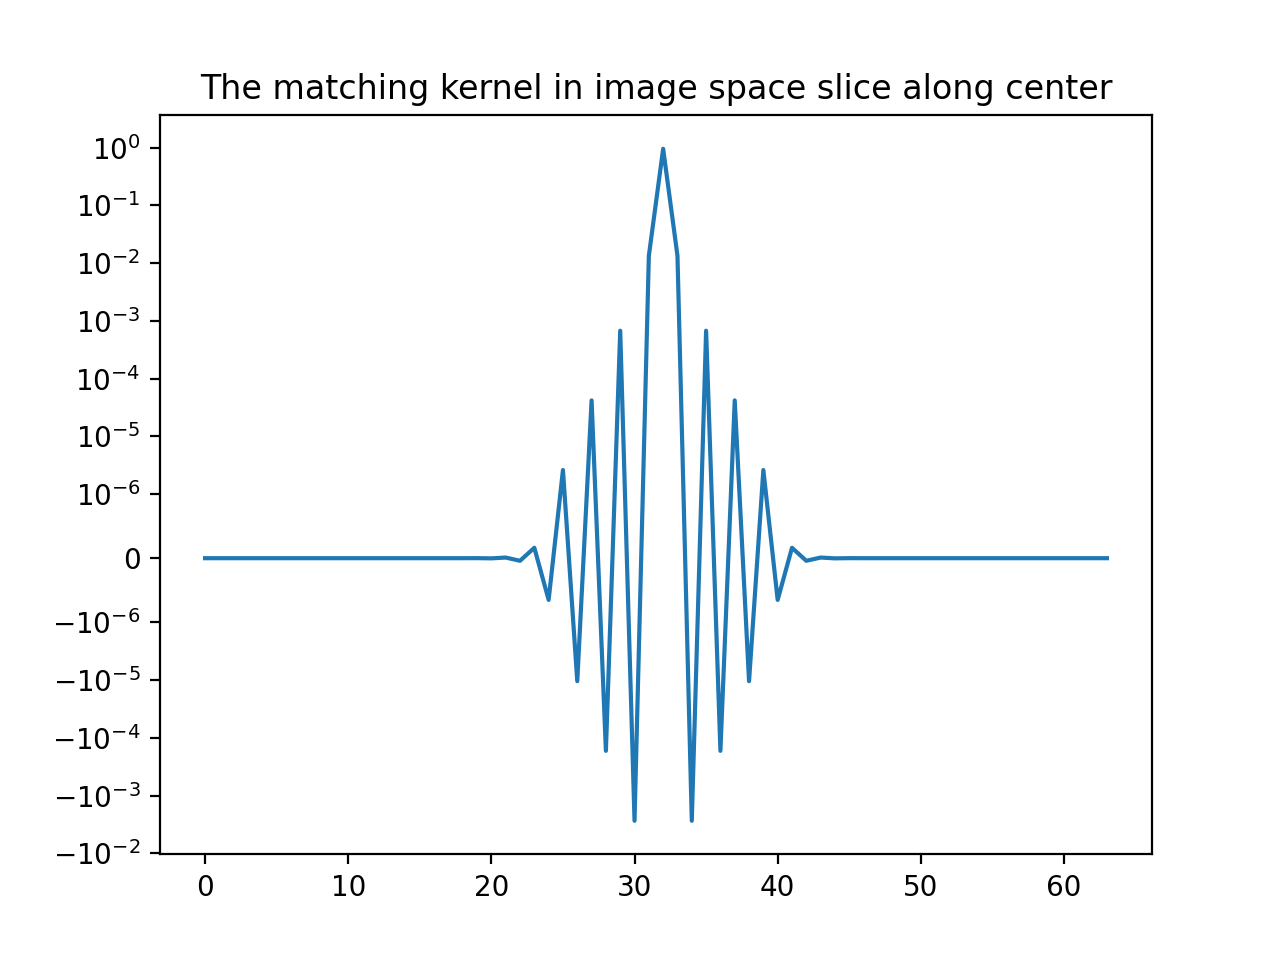

In [49]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(P2[32])
ax1.set_title("The matching kernel in image space slice along center")
ax1.set_yscale("symlog", linthresh=1e-6)

<IPython.core.display.Javascript object>


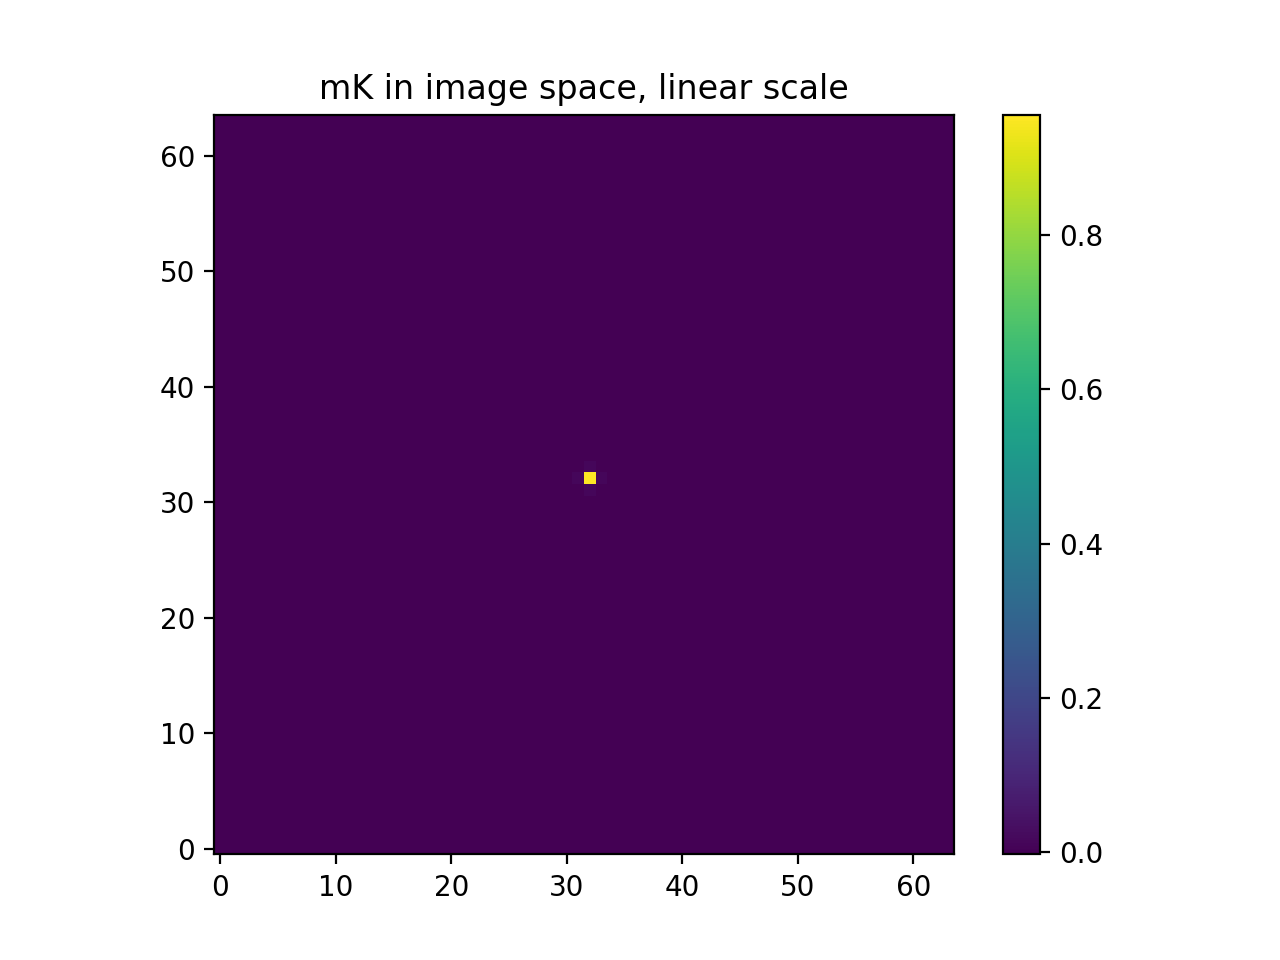

In [50]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
P2 = task.padCenterOriginArray(mK, (N, N), useInverse=True)
cs = ax1.imshow(P2, origin='lower', interpolation='none')
ax1.set_title("mK in image space, linear scale")
fig.colorbar(cs)

No shift in the input PSFs.

In [51]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


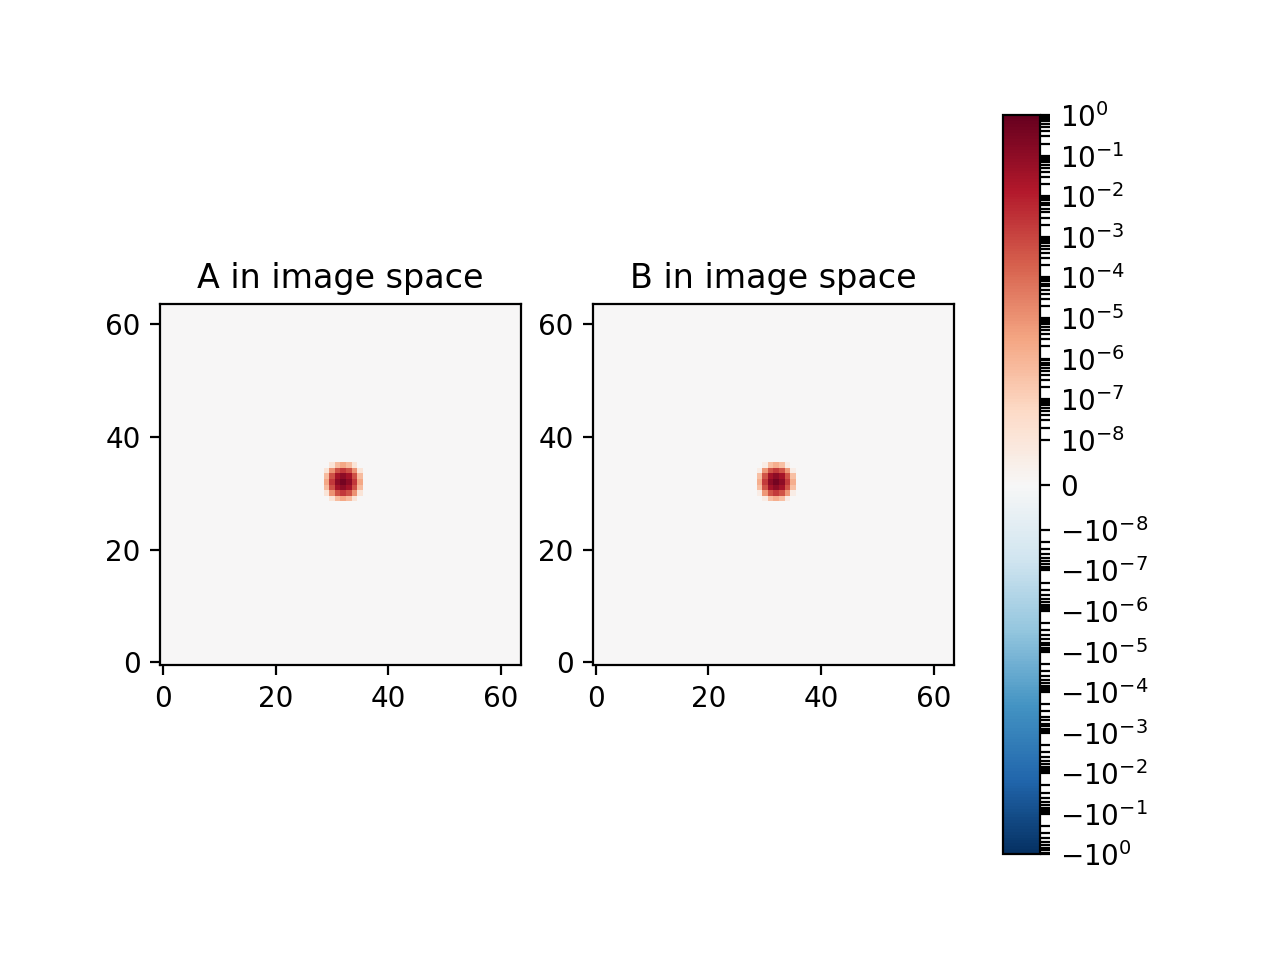

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


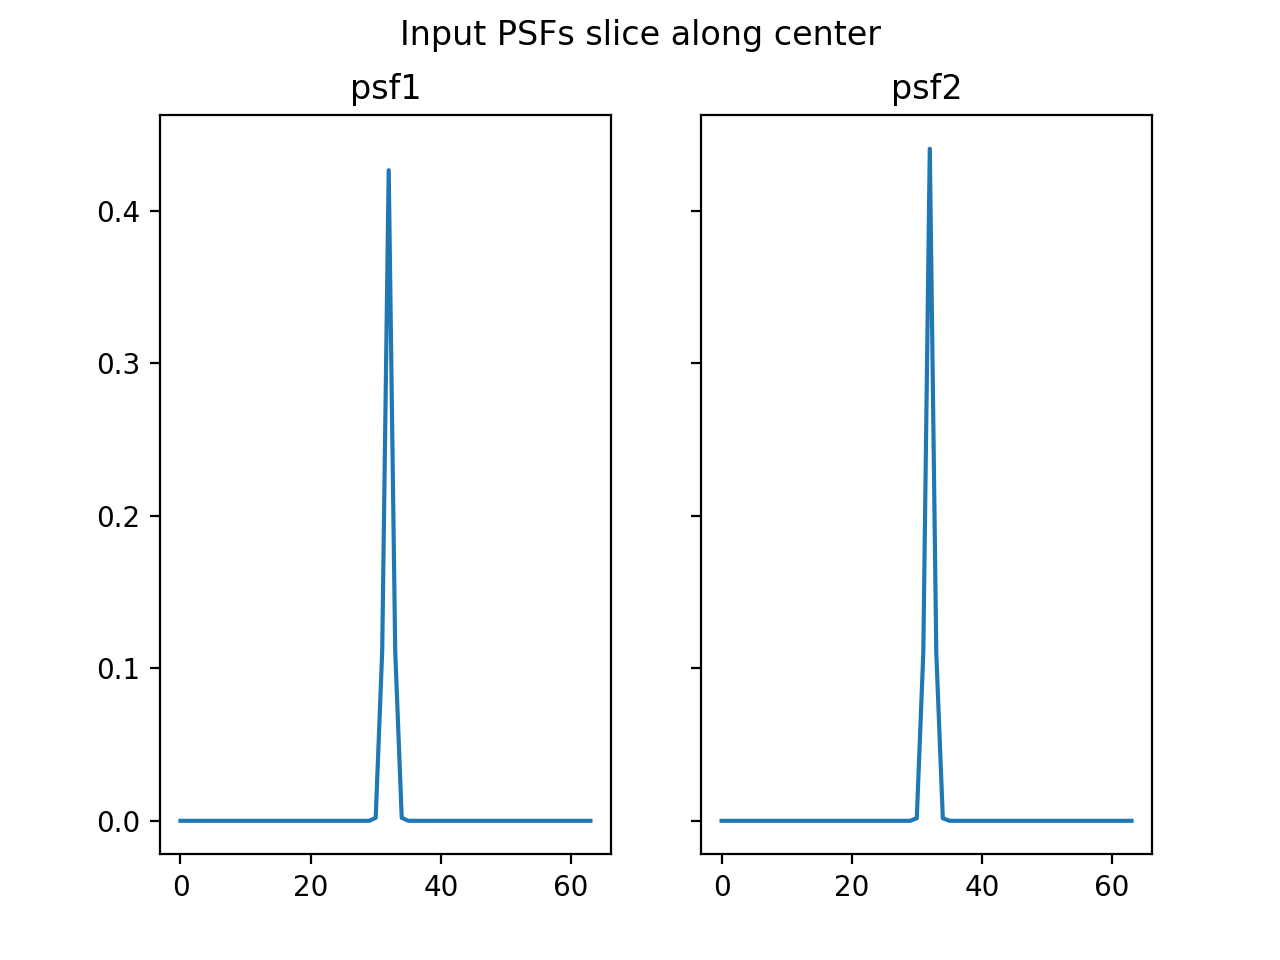

Text(0.5, 0.98, 'Input PSFs slice along center')

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [54]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


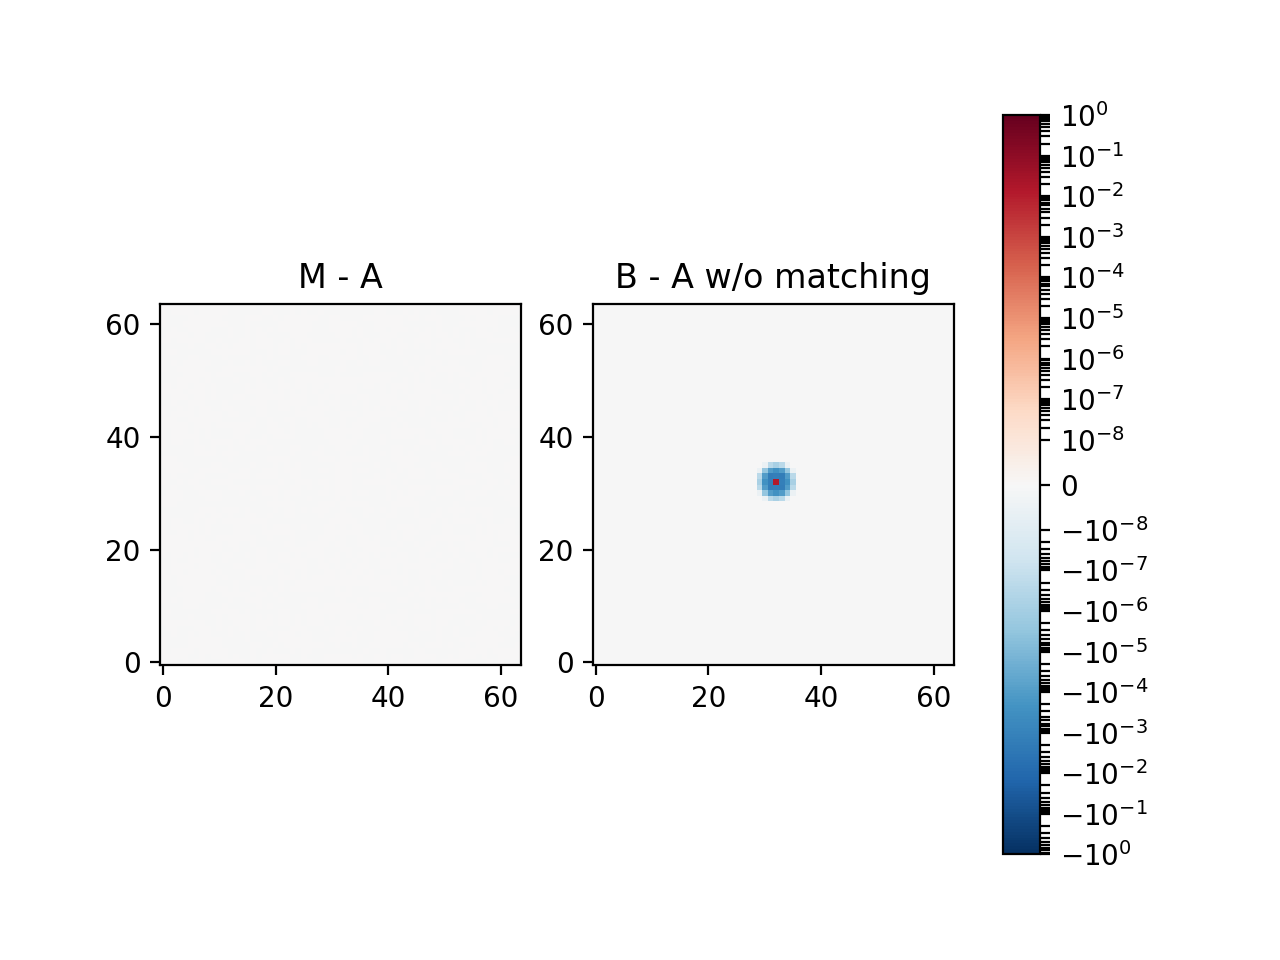

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


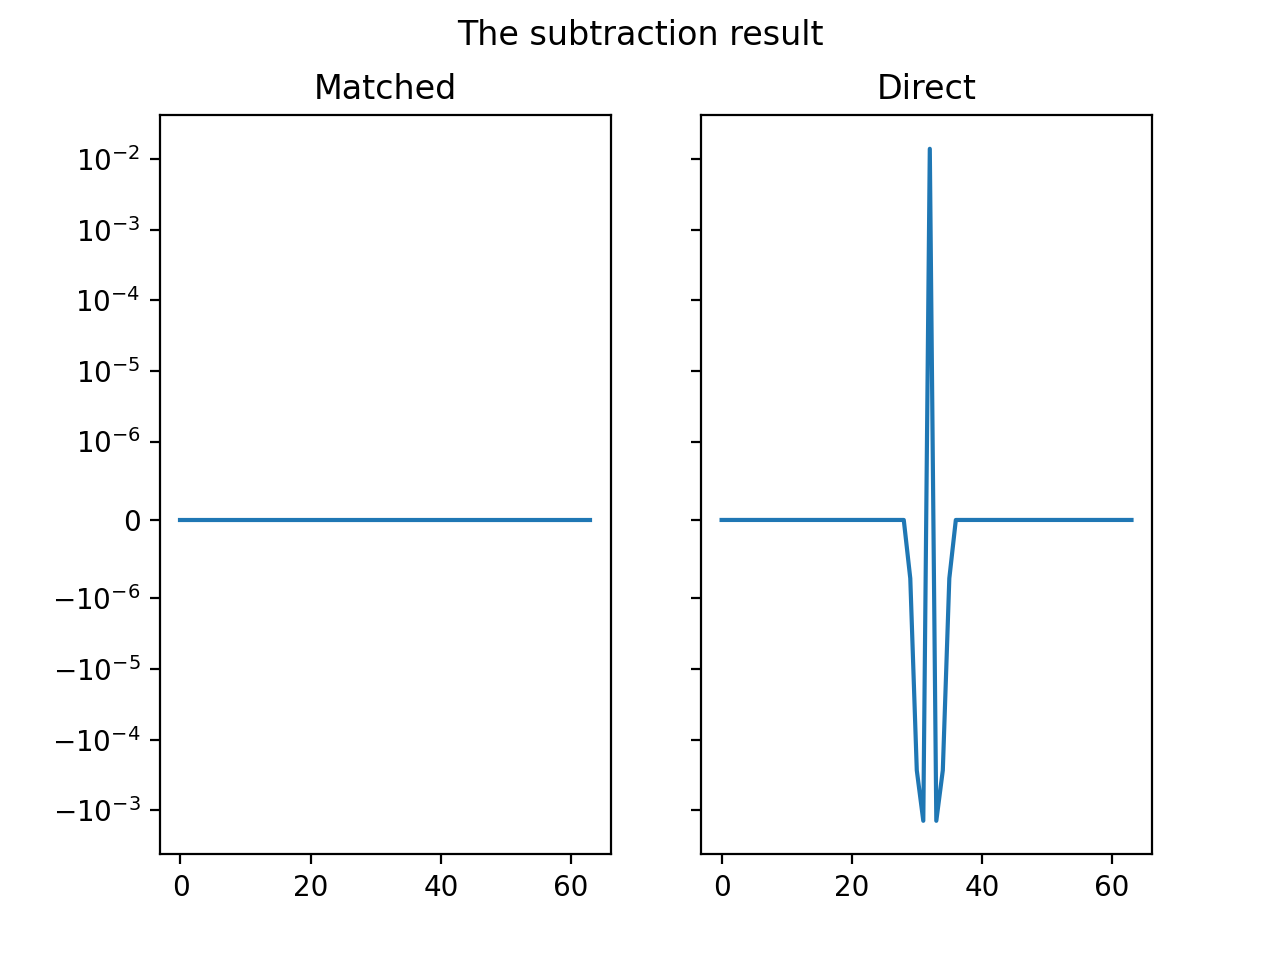

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-6)

-----------

Shift inputs by 0.1 pixel (in both direction)

In [57]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
B = scipy.ndimage.shift(B, 0.1, mode='constant')

pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


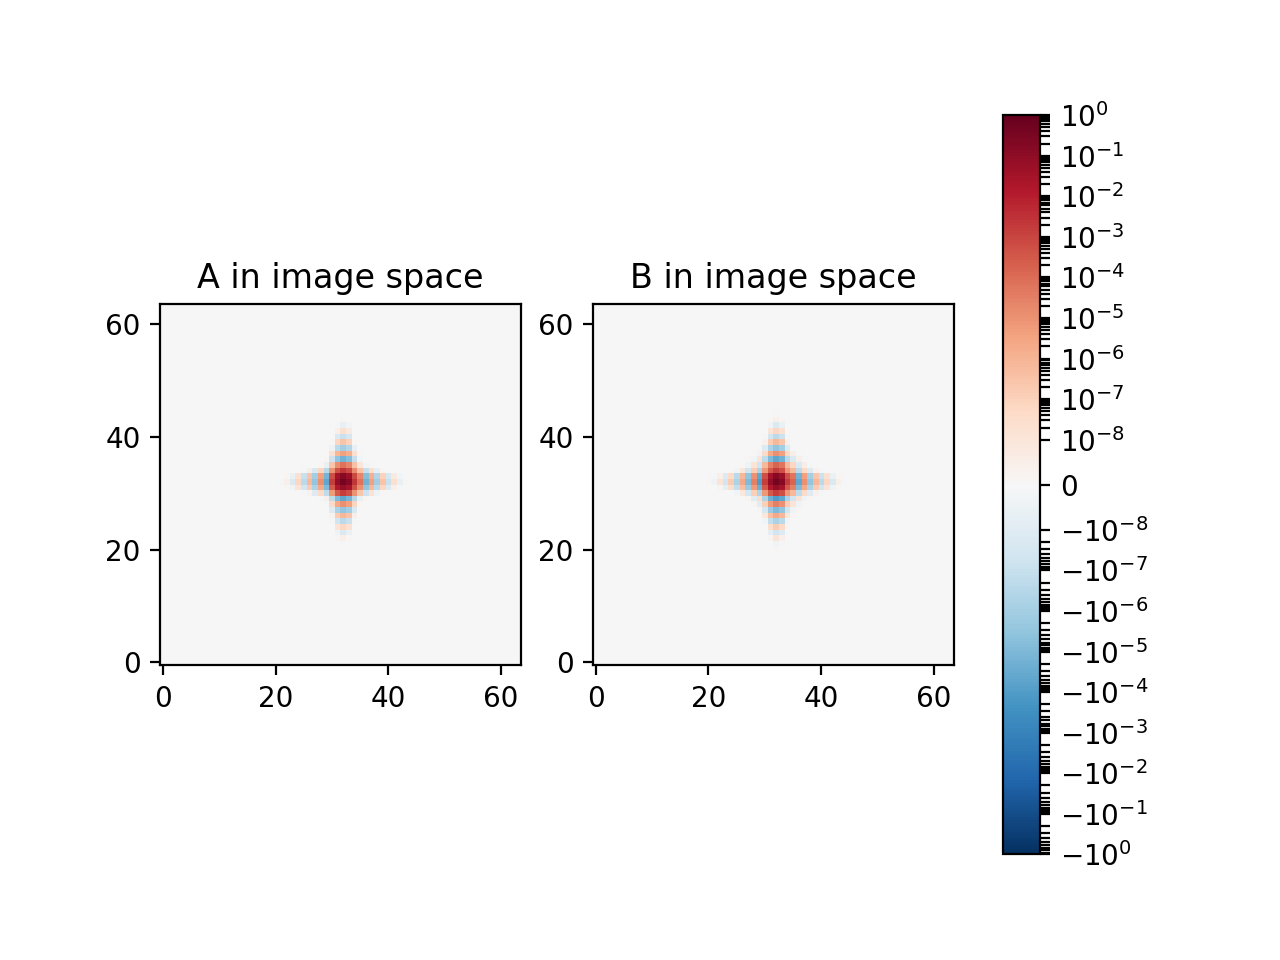

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


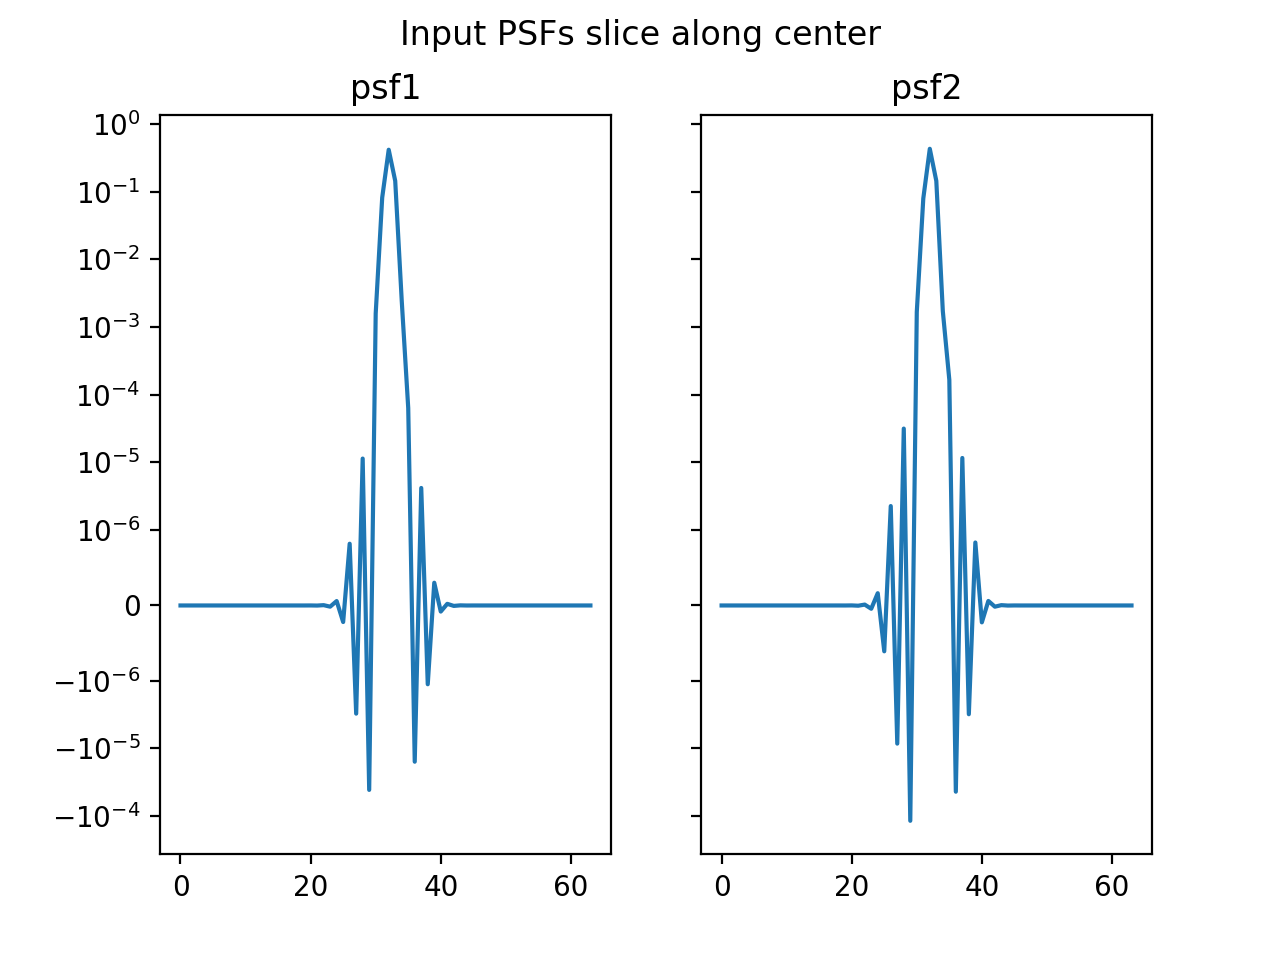

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")
ax2.set_yscale("symlog", linthresh=1e-6)

In [60]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


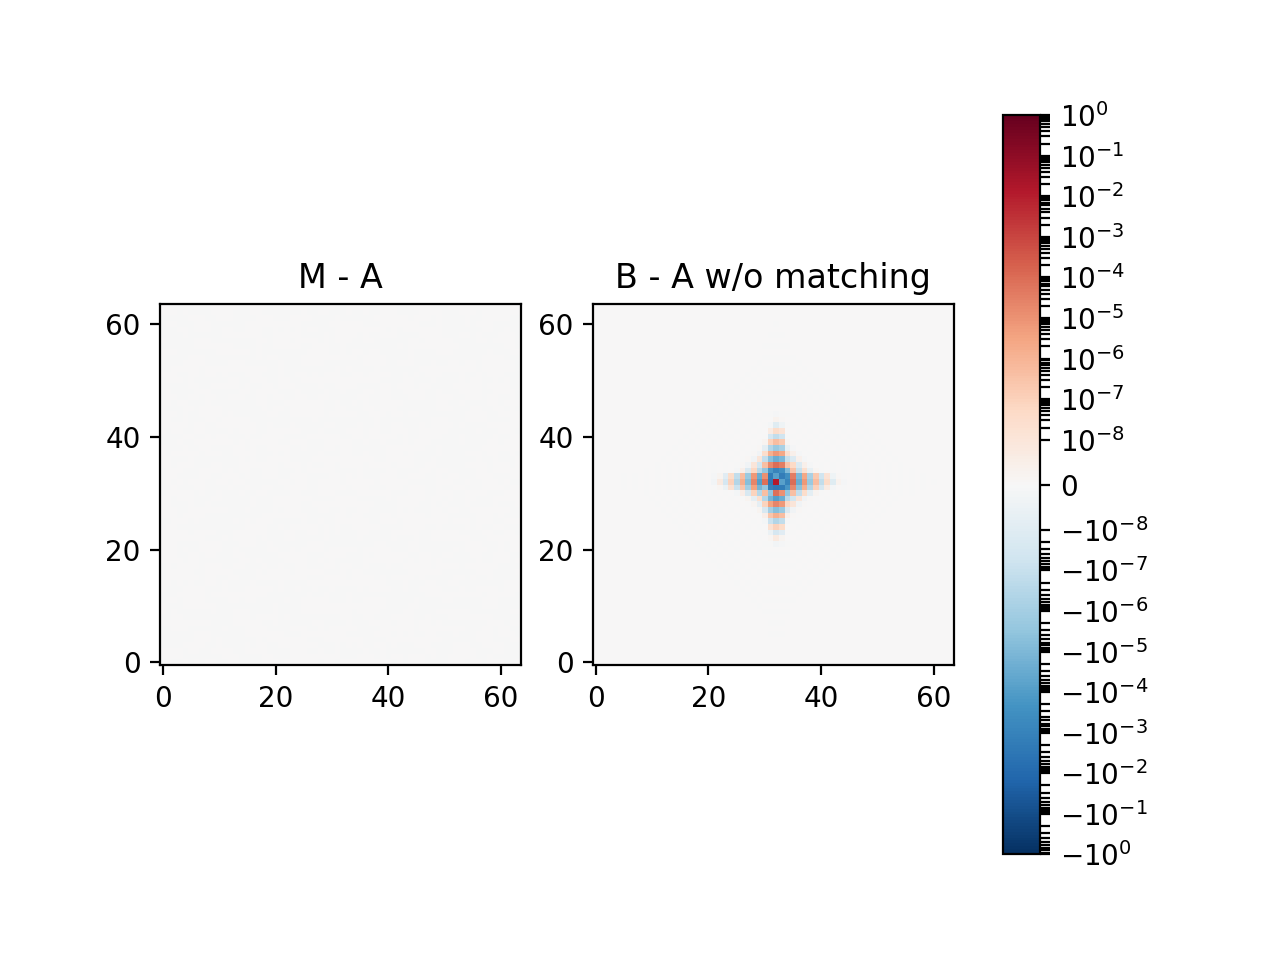

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


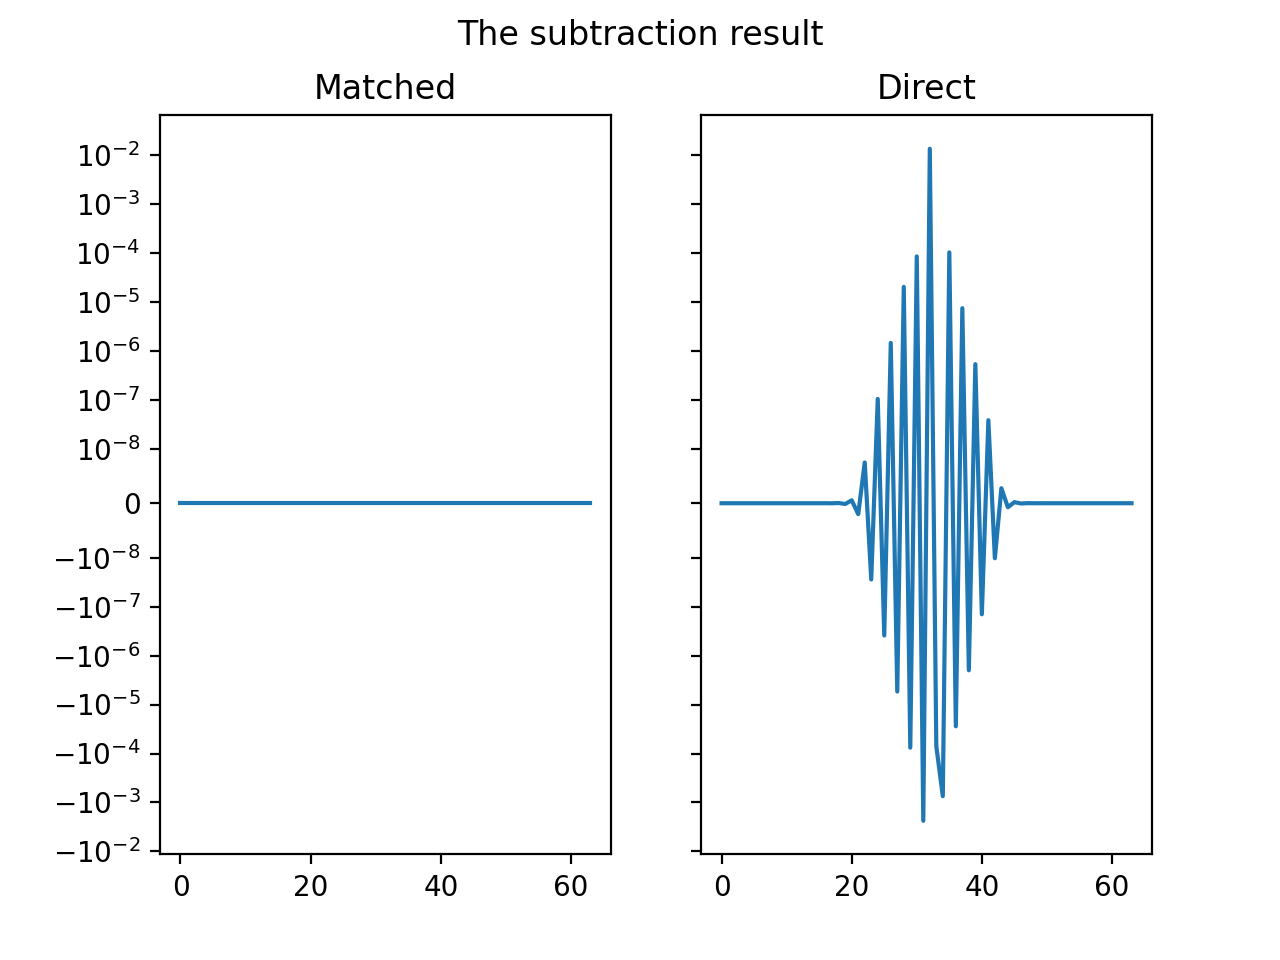

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-8)

------

One input is saturated (the PSF has edges).

In [63]:
A = calculate2dGaussianArray(N, N, wSig1)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
A /= np.sum(A)
B = calculate2dGaussianArray(N, N, wSig2)
B = scipy.ndimage.shift(B, 0.1, mode='constant')
thr = np.max(B) * 0.5
flt = B>thr
B[flt] = thr
B /= np.sum(B)
pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


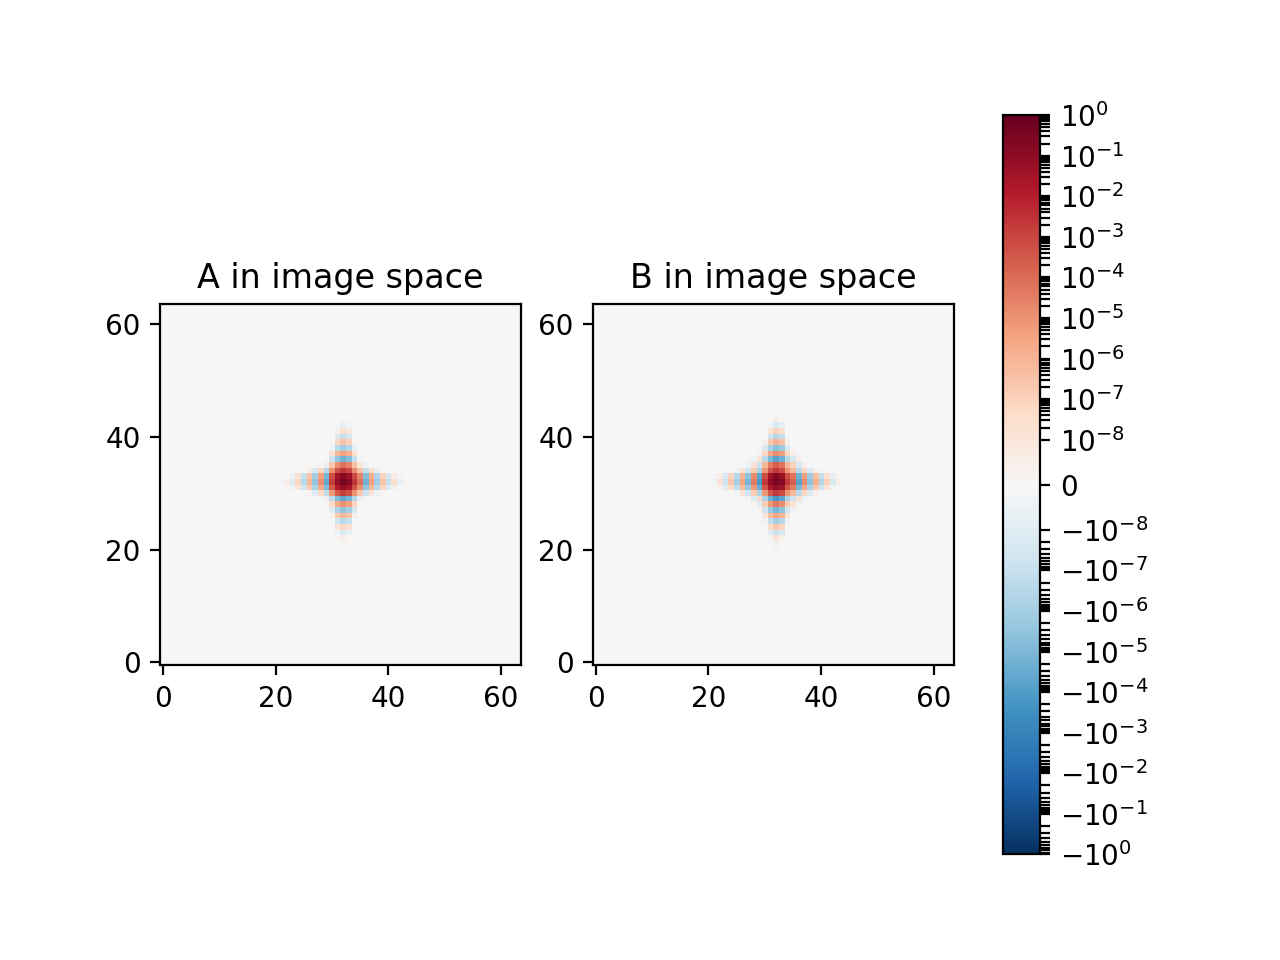

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


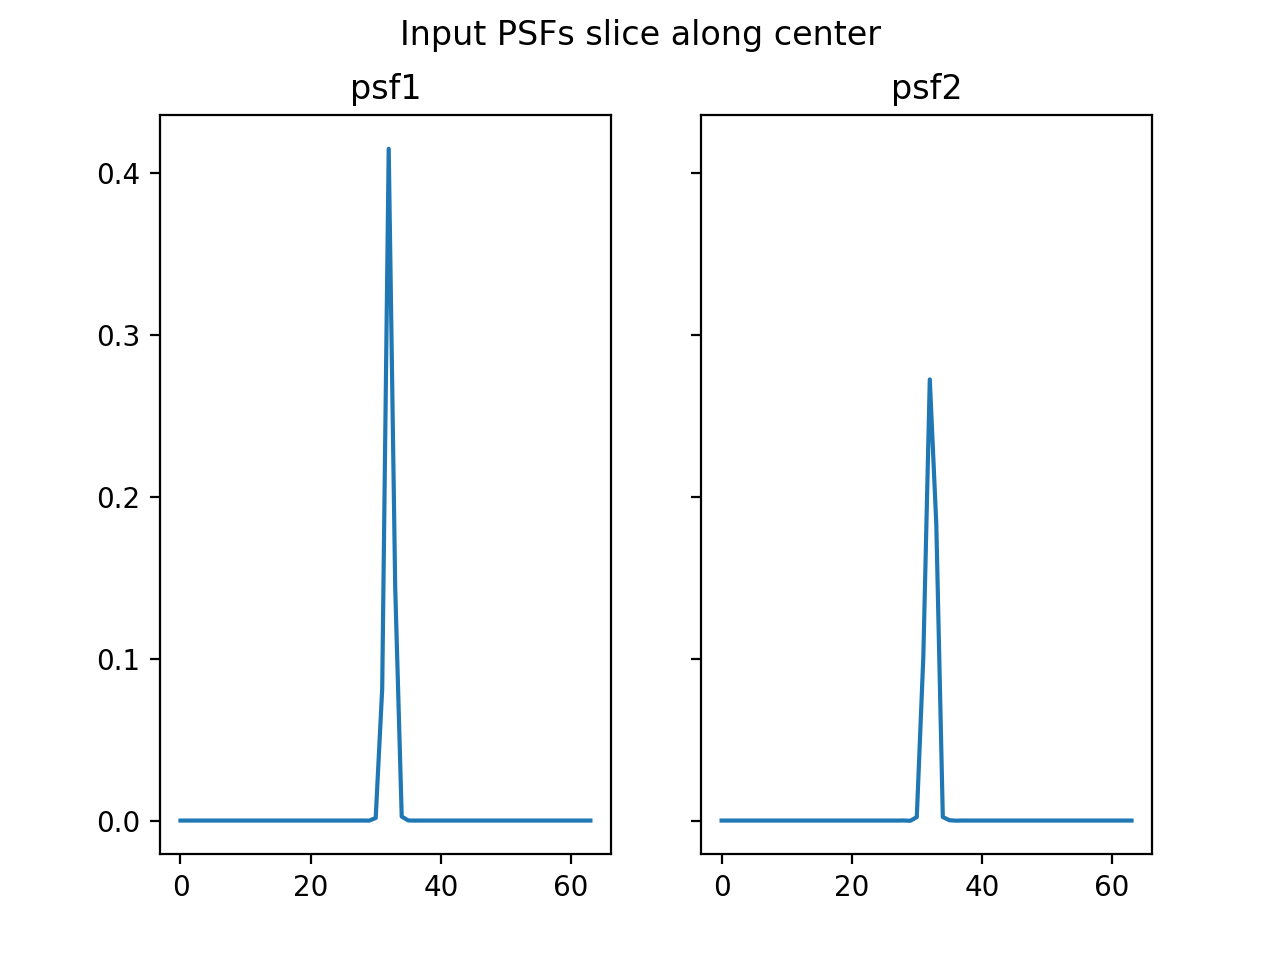

Text(0.5, 0.98, 'Input PSFs slice along center')

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")

In [66]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


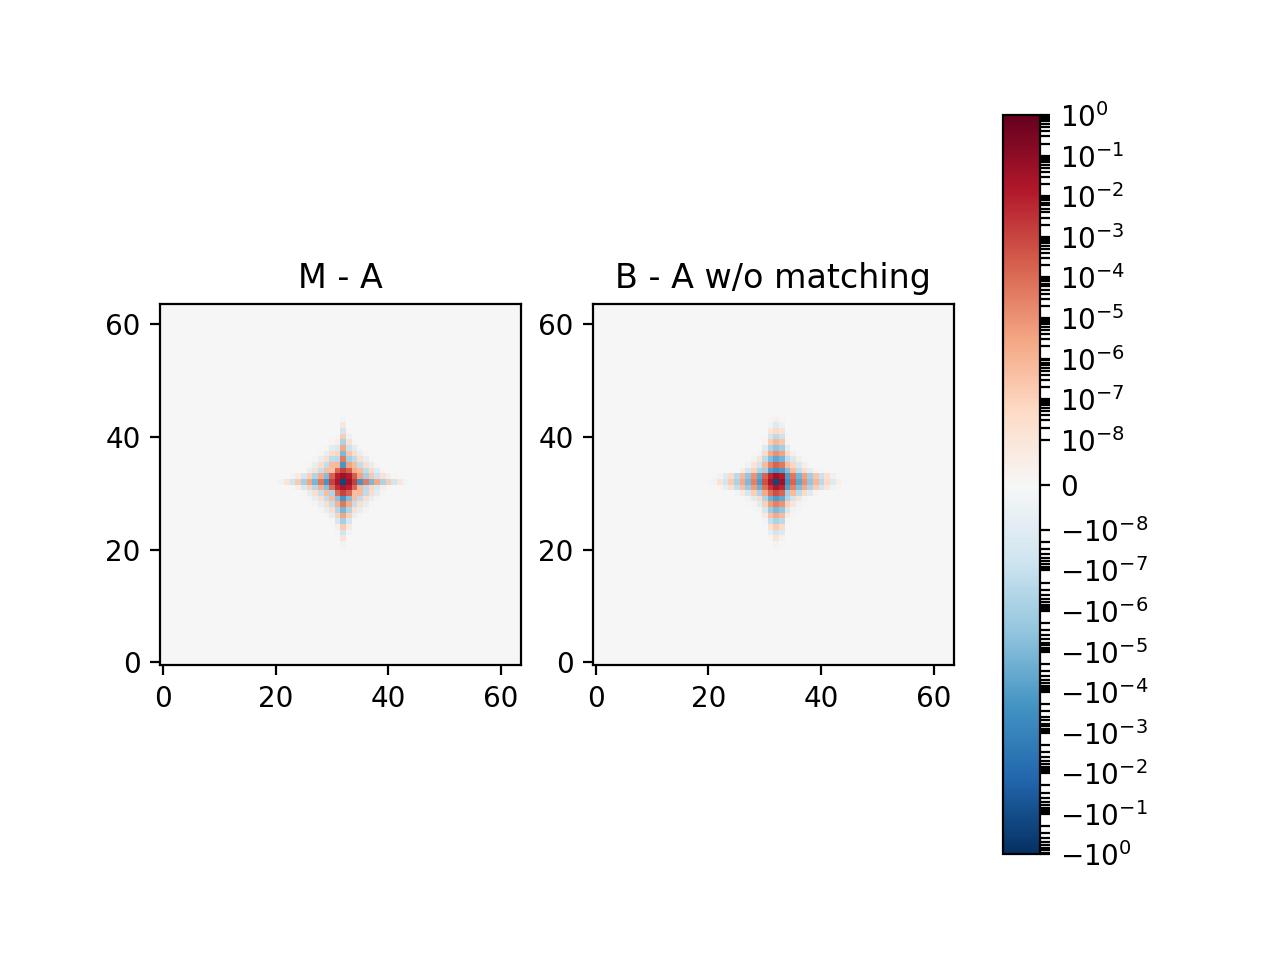

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


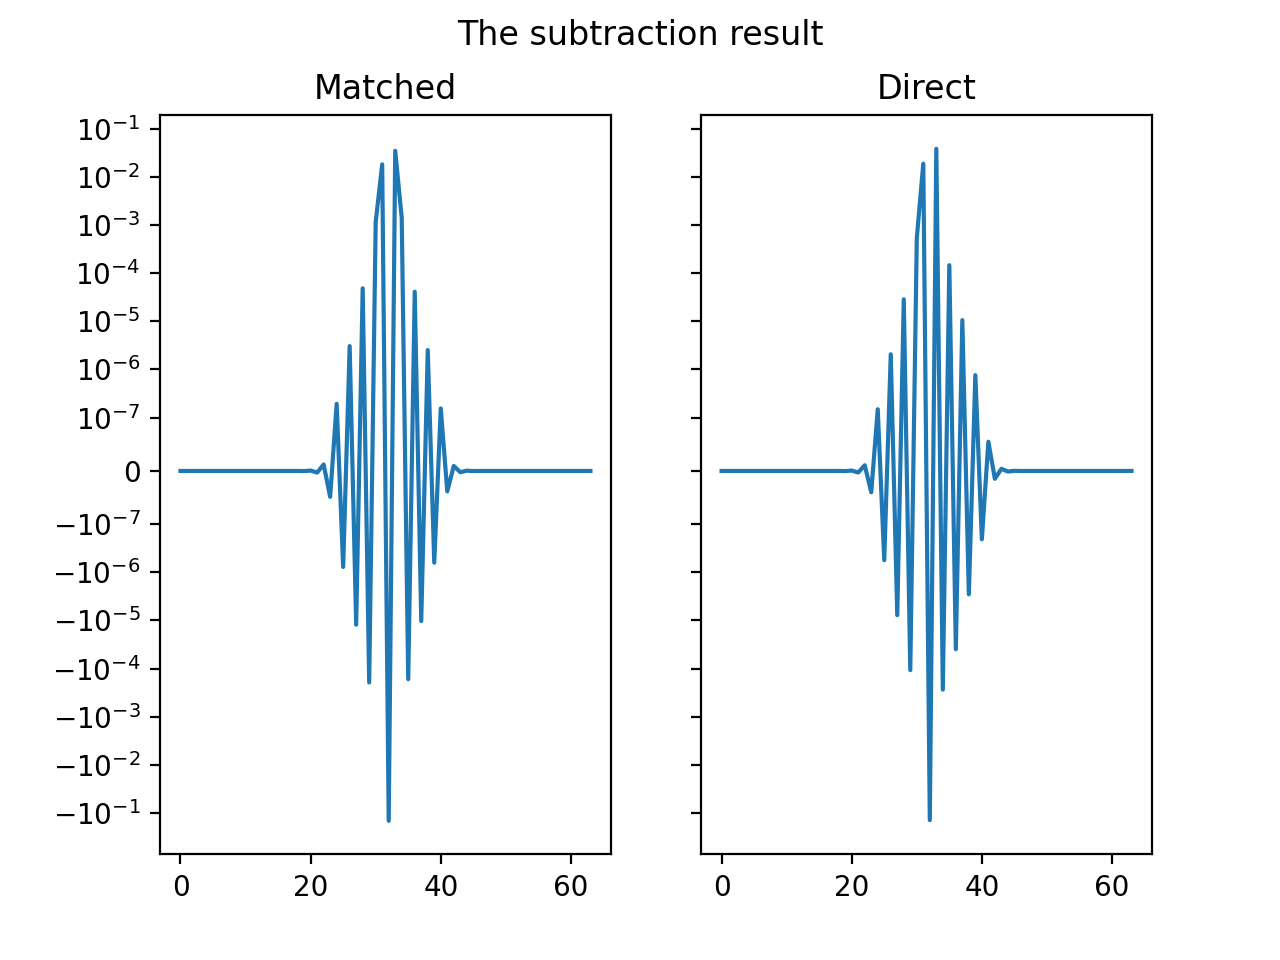

In [68]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-7)

-------

Centroid error of 0.01 pixel

In [69]:
A = calculate2dGaussianArray(N, N, wSig1)
A /= np.sum(A)
A = scipy.ndimage.shift(A, 0.1, mode='constant')
B = calculate2dGaussianArray(N, N, wSig2)
B /= np.sum(B)
B = scipy.ndimage.shift(B, 0.11, mode='constant')

pA = task.padCenterOriginArray(A, (N, N))
psf1 = np.fft.fft2(pA)
pB = task.padCenterOriginArray(B, (N, N))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


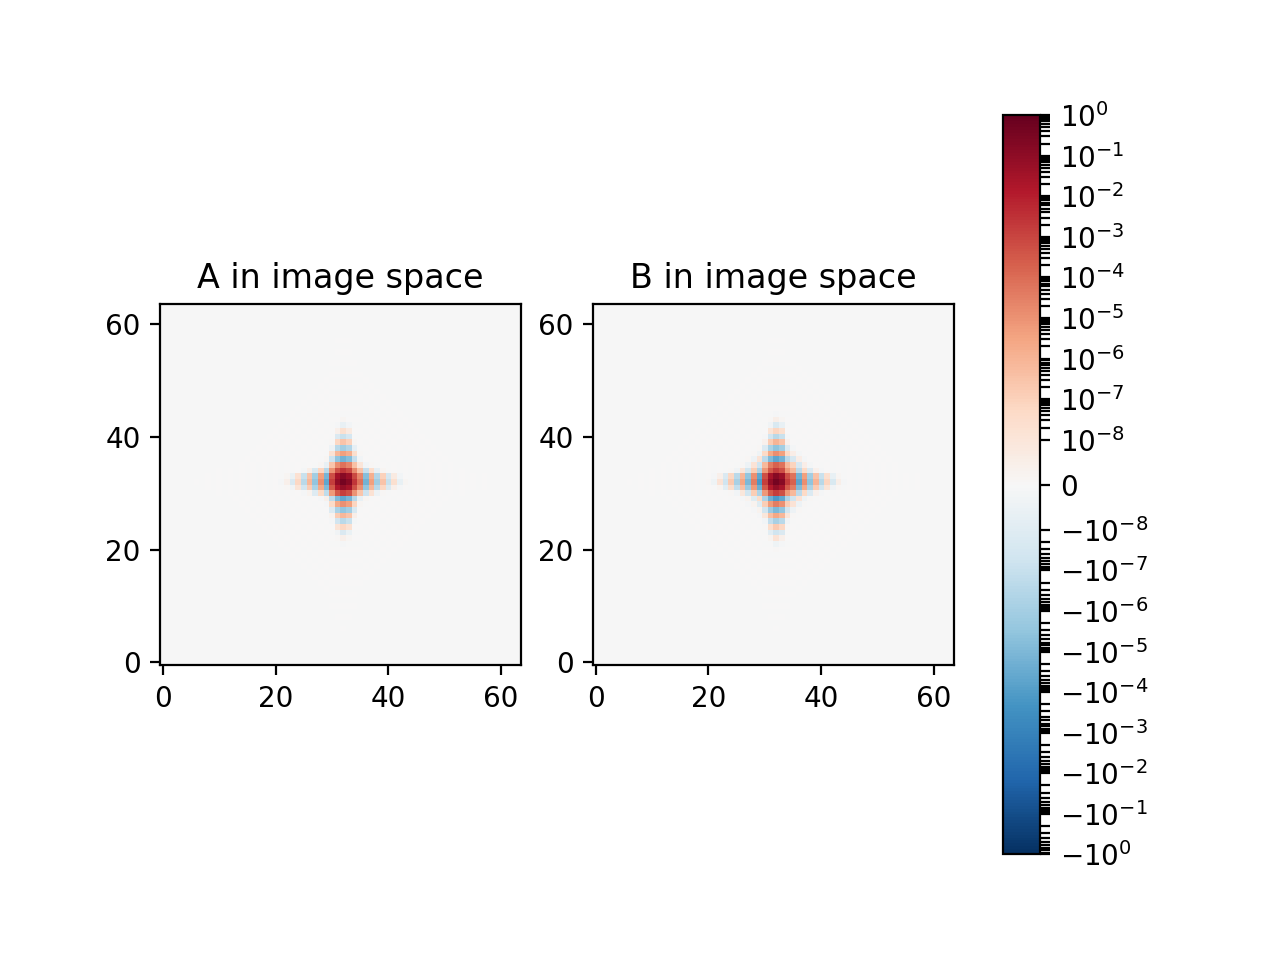

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cs = ax1.imshow(A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("A in image space")
cs = ax2.imshow(B, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B in image space")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


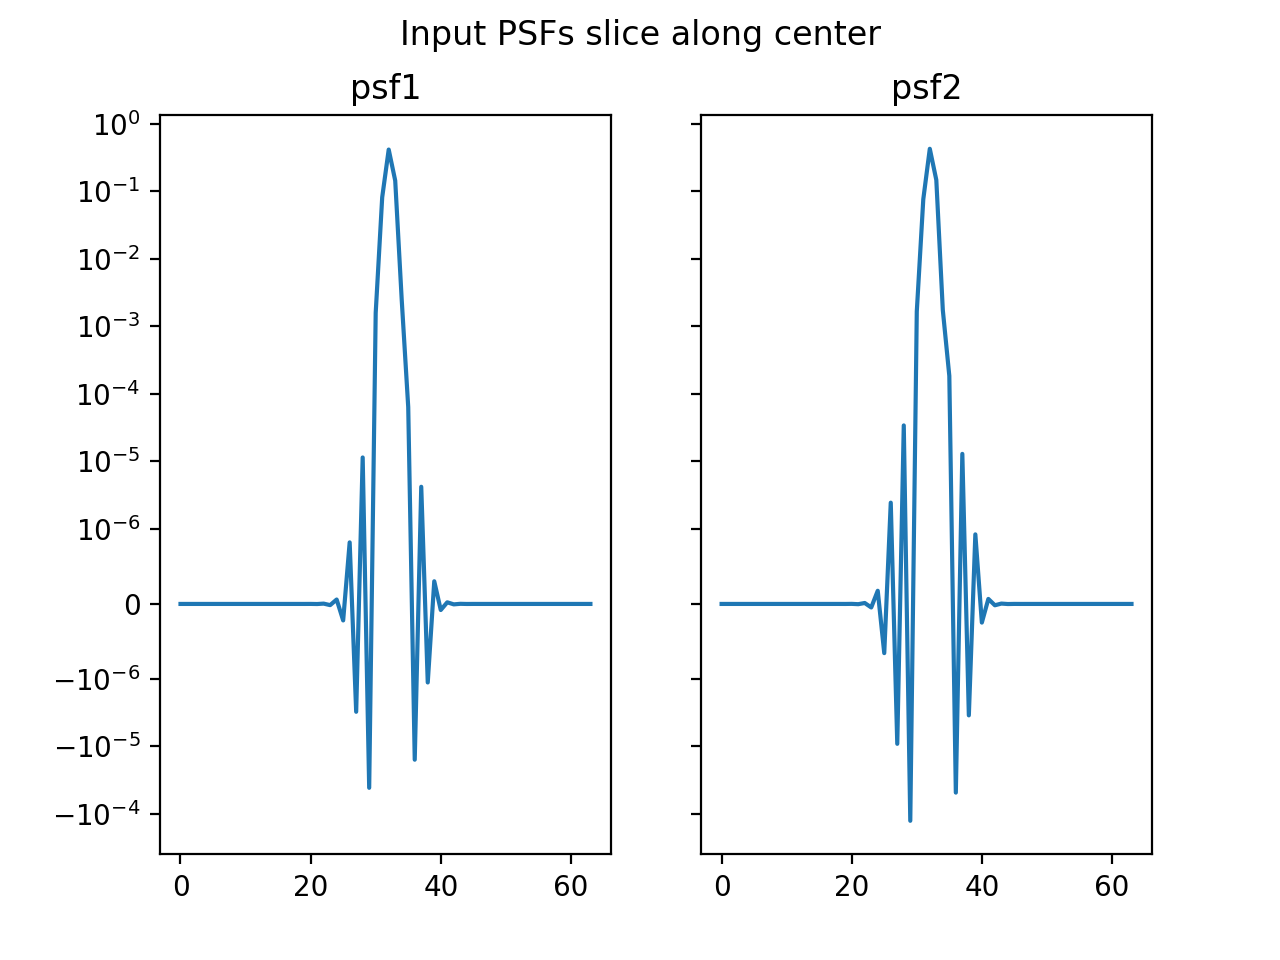

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot(A[32])
ax1.set_title("psf1")
cs = ax2.plot(B[32])
ax2.set_title("psf2")
fig.suptitle("Input PSFs slice along center")
ax2.set_yscale("symlog", linthresh=1e-6)

In [72]:
pM = psf2 * fmK
M = np.fft.ifft2(pM)
M = M.real

<IPython.core.display.Javascript object>


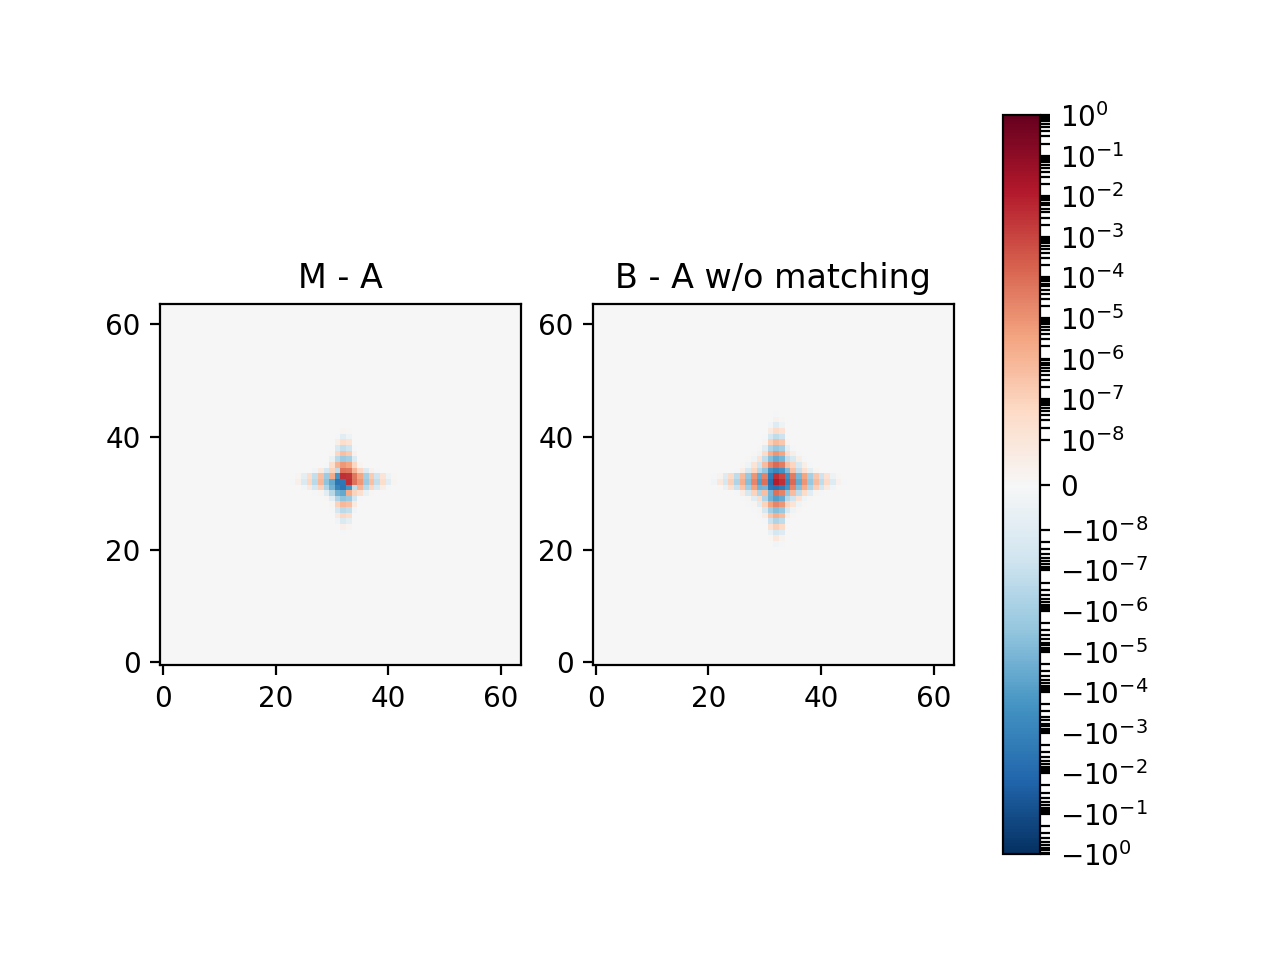

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
P2 = task.padCenterOriginArray(M, (N, N), useInverse=True)
cs = ax1.imshow(P2 - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax1.set_title("M - A")
cs = ax2.imshow(B - A, origin='lower', interpolation='none', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8, base=10, vmin=-1, vmax=1))
ax2.set_title("B - A w/o matching")
fig.colorbar(cs, ax = [ax1, ax2])

<IPython.core.display.Javascript object>


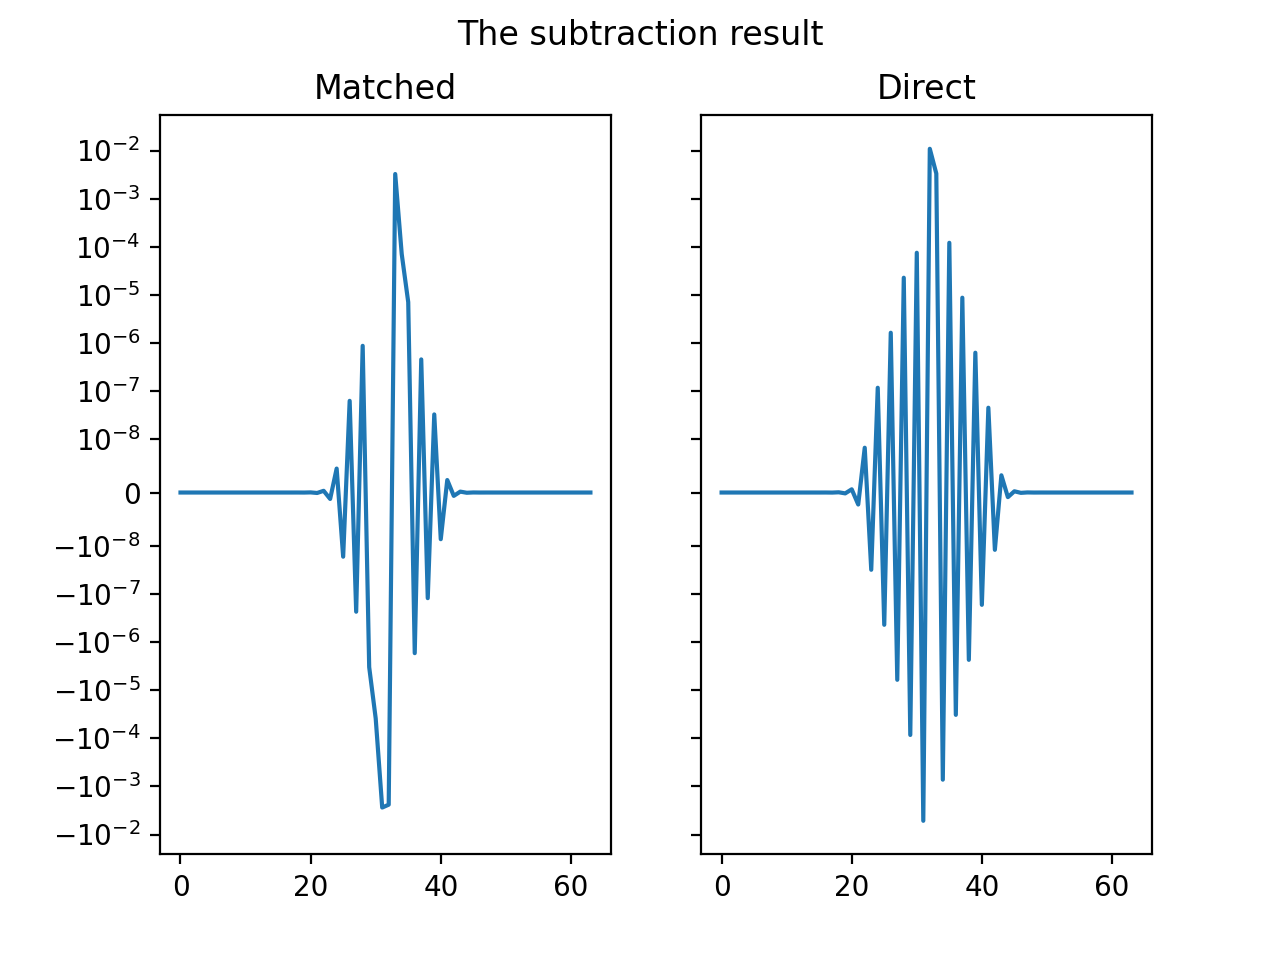

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
cs = ax1.plot((P2-A)[32])
ax1.set_title("Matched")
cs = ax2.plot((B-A)[32])
ax2.set_title("Direct")
fig.suptitle("The subtraction result")
ax1.set_yscale("symlog", linthresh=1e-8)